# PyTorch에서 데이터 다루기

## Dataset 살펴보기 : 간단한 데이터

### Dataset 클래스 만들기

In [1]:
import torch

Dataset 클래스는 데이터셋과 레이블을 관리하기 편리하게 만들어 주는 PyTorch의 유틸리티입니다. 커스텀 데이터셋을 정의하면, 데이터셋의 크기와 특정 인덱스 데이터를 쉽게 확인할 수 있습니다.

이번 예제에서는 간단한 2차원 데이터와 이진 레이블을 활용해 Dataset 클래스를 만들어보겠습니다.

In [2]:
# Dataset 클래스를 상속받아 커스텀 데이터셋을 정의합니다.
from torch.utils.data import Dataset

사용자 정의 Dataset 클래스는 __init__ , __len__ , __getitem__ 의 세 가지 함수를 구현해야 합니다

- `__init__` 메소드는 클래스가 초기화될 때 실행됩니다. 데이터의 경로나 전처리를 정의하며, 간단한 데이터라면 여기에서 바로 데이터를 정의할 수도 있습니다.

- `__len__` 메소드는 데이터 셋에 있는 샘플의 개수를 반환합니다.

- `__getitem__` 메소드는 특정 인덱스의 데이터를 반환합니다.

In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        self.x = [
            [10,20],
            [25,15],
            [15,15],
            [30,40],
            [80,85],
            [90,85],
        ]
        self.y = [0,0,0,1,1,1]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        input_data = self.x[index]
        label = self.y[index]
        return torch.tensor(input_data), torch.tensor(label)

### Dataset 객체 사용하기

In [4]:
### 객체 생성
custom_dataset = CustomDataset()

In [5]:
### 데이터 개수 확인
len(custom_dataset)

6

In [6]:
### 특정 인덱스 데이터 확인
custom_dataset[0]

(tensor([10, 20]), tensor(0))

## CSV 데이터 활용하기

 실제 데이터를 담고 있는 CSV 파일을 활용하여 PyTorch의 Dataset 클래스를 정의하고 사용하는 방법을 배워보겠습니다.

In [7]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

전복(Abalone) 데이터셋을 판다스를 사용해 읽어옵니다.

이 데이터는 전복의 크기, 무게, 그리고 나이 정보를 포함하고 있습니다.

In [8]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

In [9]:
abalone_df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


결과를 보면, 길이, 직경, 높이 같은 크기 정보와 무게, 나이 정보가 잘 나옵니다.

이 데이터를 사용하여 전복의 나이를 예측하는 회귀 문제를 설정하겠습니다.

- **`input_data`**: 나이를 제외한 나머지 데이터 (입력)
- **`target_data`**: 전복의 나이 (타깃)

In [10]:
input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

In [11]:
class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        
        return input_tensor, target_tensor

In [12]:
abalone_dataset = AbaloneDataset(input_data=input_data, target_data=target_data)
print(len(abalone_dataset))
print(abalone_dataset[2][0])

3320
tensor([0.6550, 0.5100, 0.1600, 1.0920, 0.3960, 0.2825, 0.3700])


## 이미지 데이터

데이터 크기가 너무 커서 메모리에 모두 올리기 어려운 경우를 대비해 PyTorch Dataset 클래스를 활용하는 방법을 배워봅니다.

In [13]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [14]:
# 다양한 꽃 이미지 데이터가 담긴 flower_photos 폴더를 다운로드하고 압축을 해제합니다.

# !wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
# !tar -xvf ./flower_photos.tgz > /dev/null 2>&1


In [15]:
import os
import tarfile
import urllib.request

# 경로 설정 및 폴더 생성
base_dir = './content'
os.makedirs(base_dir, exist_ok=True)
target_path = os.path.join(base_dir, "flower_photos.tgz")

# 다운로드 및 압축 해제
if not os.path.exists(target_path):
    urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz", target_path)

if not os.path.exists(os.path.join(base_dir, "flower_photos")):
    with tarfile.open(target_path, "r:gz") as tar:
        tar.extractall(path=base_dir)

# 최종 경로 변수 설정
image_path = './content/flower_photos/*/*.jpg'

In [16]:
import glob
image_path_all = glob.glob("./content/**/*.jpg", recursive=True)
image_path_all

['./content\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg',
 './content\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg',
 './content\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg',
 './content\\flower_photos\\daisy\\10172567486_2748826a8b.jpg',
 './content\\flower_photos\\daisy\\10172636503_21bededa75_n.jpg',
 './content\\flower_photos\\daisy\\102841525_bd6628ae3c.jpg',
 './content\\flower_photos\\daisy\\1031799732_e7f4008c03.jpg',
 './content\\flower_photos\\daisy\\10391248763_1d16681106_n.jpg',
 './content\\flower_photos\\daisy\\10437754174_22ec990b77_m.jpg',
 './content\\flower_photos\\daisy\\10437770546_8bb6f7bdd3_m.jpg',
 './content\\flower_photos\\daisy\\10437929963_bc13eebe0c.jpg',
 './content\\flower_photos\\daisy\\10466290366_cc72e33532.jpg',
 './content\\flower_photos\\daisy\\10466558316_a7198b87e2.jpg',
 './content\\flower_photos\\daisy\\10555749515_13a12a026e.jpg',
 './content\\flower_photos\\daisy\\10555815624_dc211569b0.jpg',
 './content\\flower_photos\\daisy

In [17]:
from torchvision.transforms import v2
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]
)

In [18]:
class FlowerDataset(Dataset):
    def __init__(self, transform):
        self.image_paths = glob.glob('./content/flower_photos/*/*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        output = self.transform(image)
        # self.t(image, self.transform)
        return output

In [19]:
dataset = FlowerDataset(transform)

In [20]:
len(dataset)

3670

In [21]:
type(dataset[0])

torchvision.tv_tensors._image.Image

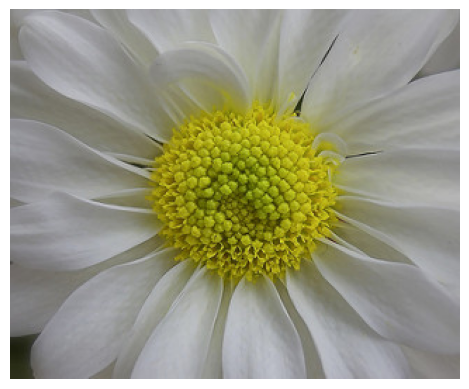

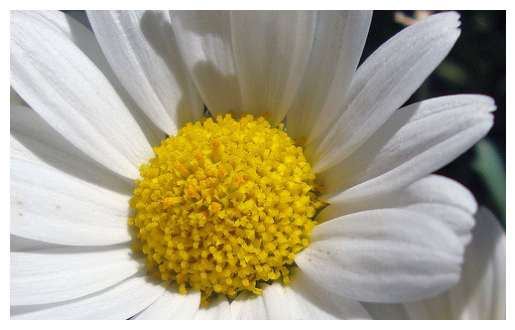

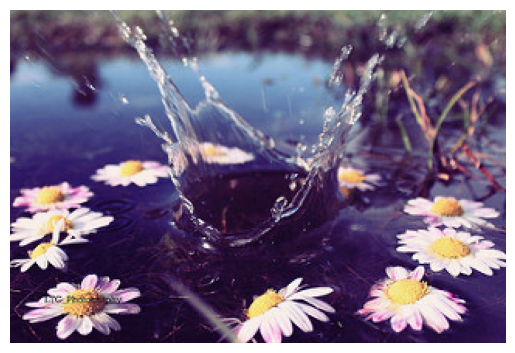

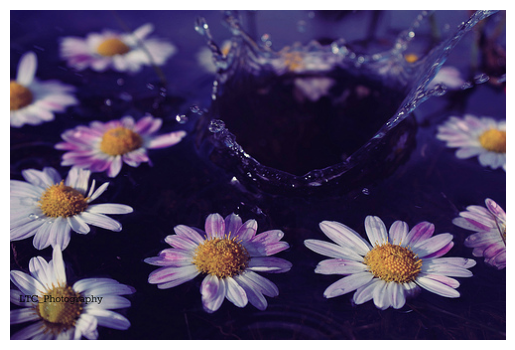

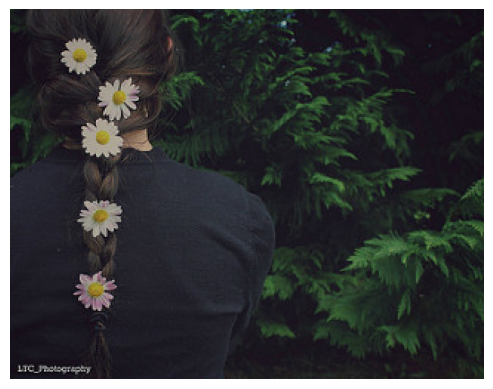

In [22]:
import matplotlib.pyplot as plt

def show_image(image_tensor):
    image = image_tensor.numpy()
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

for i in range(5):
    show_image(torch.permute(dataset[i], (1,2,0)))

## 실습

scikit-learn에서 California Housing 데이터셋을 불러온 뒤, 입력은 `input_data`에 저장하고 타깃은 `target_data`에 저장하세요.이때 `input_data`와 `target_data` 모두 데이터 타입은 float32로 지정해주세요.

California Housing 데이터셋의 입력과 타깃을 짝지어 관리하는 커스텀 Dataset 클래스 `CaliforniaHousingDataset`을 정의해 주세요.
   
코드 마지막 부분에서 0번 인덱스 데이터를 출력했을 때 다음과 같은 결과가 나와야 합니다.



```
(tensor([   8.3252,   41.0000,    6.9841,    1.0238,  322.0000,    2.5556,
          37.8800, -122.2300]), tensor(4.5260))
```

In [23]:
import numpy as np
from sklearn import datasets

import torch
from torch.utils.data import Dataset

cal_housing = datasets.fetch_california_housing()
input_data = cal_housing.data.astype(np.float32)
target_data = cal_housing.target.astype(np.float32)

In [24]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

In [25]:
dataset = CaliforniaHousingDataset(input_data, target_data)
print(dataset[0])

(tensor([   8.3252,   41.0000,    6.9841,    1.0238,  322.0000,    2.5556,
          37.8800, -122.2300]), tensor(4.5260))


## 데이터 분할과 표준화

PyTorch에서 데이터셋을 학습, 검증, 테스트로 분할하고, 데이터를 표준화하는 과정을 배웁니다.

In [26]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

### 데이터 분할

여기서 데이터를 분할한다는 건, 학습, 검증, 테스트에 서로 다른 데이터가 사용되도록 나누는 걸 뜻해요.

모델 학습이 얼마나 잘 됐는지 똑바로 평가하려면, 학습 과정에서 이미 사용한 데이터가 아닌 다른 데이터가 필요합니다.

그래서 검증 데이터나 테스트 데이터를 따로 확보해 두는 거예요.

예를 들어서, 전체 데이터 중 80퍼센트를 학습에 사용하고, 10퍼센트는 검증용으로, 나머지 10퍼센트는 테스트용으로 사용한다고 해 보겠습니다.

In [27]:
# 데이터를 학습, 검증, 테스트로 나누기
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

In [28]:
# 각 데이터 셋 객체 생성
train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size: train_size + val_size]
val_targets = target_data[train_size: train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

In [29]:
train_dataset = AbaloneDataset(train_inputs, train_targets)
val_dataset = AbaloneDataset(val_inputs, val_targets)
test_dataset = AbaloneDataset(test_inputs, test_targets)

In [30]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2656
332
332


### 표준화


전복 데이터처럼 수치형 데이터를 사용할 때는, 각 피처마다 평균이 0, 표준편차가 1이 되도록 표준화를 해 주는 경우가 많습니다.

그래야 피처의 스케일에 영향을 받지 않고, 모델을 더 안정적으로 학습시킬 수 있거든요.

파이토치에서 데이터를 표준화할 때는 주로 싸이킷런의 도움을 받습니다.

먼저 싸이킷런 프리프로세싱 모듈에서 스탠다드 스케일러를 임포트하고,,, 바로 스탠다드 스케일러 객체를 만들어 줄게요.

먼저 fit 메소드에 학습 입력 데이터를 넣어 주겠습니다.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_inputs)

print(train_inputs.shape)

(2656, 7)


핏 메소드에 사용할 데이터는 (데이터 개수 x 피처 개수) 형태여야 합니다.

그러면 각 피처마다 모든 데이터에 대해 평균과 표준편차를 계산해서 스케일러 객체에 저장하게 됩니다.

지금처럼 train_inputs를 넣으면 전복 무게나 크기 같은 피처마다 평균과 표준편차를 구하게 됩니다.

참고로 학습 데이터로만 스케일러를 피팅하는 이유는, 검증 데이터와 테스트 데이터의 정보가 학습에 반영되면 안 되기 때문입니다.

In [32]:
# 표준화된 데이터셋 객체 생성
train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

In [33]:
print(train_inputs_scaled.mean(axis=0))
print(train_inputs_scaled.std(axis=0))

[ 7.1812827e-09 -1.5798822e-08  1.1849116e-07  1.9389462e-08
 -1.7235077e-08 -5.8168389e-08  1.4362565e-08]
[1. 1. 1. 1. 1. 1. 1.]


In [34]:
print(val_inputs_scaled.mean(axis=0))
print(val_inputs_scaled.std(axis=0))

[-0.06474355 -0.0585792  -0.04376042 -0.05980589 -0.04299598 -0.05070455
 -0.06344681]
[1.0586623  1.0502188  0.9332286  0.9754747  0.9662012  0.97565734
 0.99003077]


스케일러가 학습 데이터를 기준으로 표준화를 했기 때문에 val dataset은 정확하게 평균이 0 표준편차가 1인 데이턱 생성되지는 않는다.

In [35]:
train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)

In [36]:
data = train_dataset[0]
print(data[0])
print(train_inputs[0])

tensor([-0.7383, -0.7264, -0.6794, -1.0061, -1.0062, -0.9373, -1.0149])
[0.435  0.335  0.11   0.334  0.1355 0.0775 0.0965]


target data는 표준화를 거치지 않았기 때문에 원래의 값이 출력됨

In [37]:
# 데이터 복원
scaler.inverse_transform([data[0]])

array([[0.43500001, 0.33500001, 0.11      , 0.33399999, 0.13549999,
        0.07749999, 0.09650001]])

#### 데이터셋 클래스에 전처리 코드를 함께 넣는다면?

In [38]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset

class AbaloneDataset(Dataset):
    def __init__(self, inputs, targets, scaler=None):
        self.origin_inputs = inputs  # 복원을 위해 원본 데이터 저장
        self.targets = targets
        self.scaler = scaler
    
        self._scale_transform(inputs)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        input_data = torch.tensor(self.inputs[index], dtype=torch.float32)
        target_data = torch.tensor(self.targets[index], dtype=torch.float32)
        return input_data, target_data

    def _scale_transform(self, inputs):
        if self.scaler:
            self.inputs = self.scaler.transform(inputs)
        else:
            self.inputs = inputs
            
    def inverse_transform(self, scaled_data):
        if self.scaler:
            return self.scaler.inverse_transform(scaled_data)
        else:
            return scaled_data
    
    def log(self):
        print(f'input mean : {self.inputs.mean(axis=0)}')
        print(f'input std : {self.inputs.std(axis=0)}')

In [39]:
# 데이터 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [40]:
# 데이터셋 객체 색성
train_dataset = AbaloneDataset(train_inputs, train_targets, scaler=scaler)
val_dataset = AbaloneDataset(val_inputs, val_targets, scaler=scaler)
test_dataset = AbaloneDataset(test_inputs, test_targets, scaler=scaler)

In [41]:
# 데이터 통계 출력
train_dataset.log()

input mean : [ 7.1812827e-09 -1.5798822e-08  1.1849116e-07  1.9389462e-08
 -1.7235077e-08 -5.8168389e-08  1.4362565e-08]
input std : [1. 1. 1. 1. 1. 1. 1.]


In [42]:
train_data = train_dataset[0]
origin_data = train_dataset.inverse_transform([train_data[0].numpy()])

print(train_data)
print(origin_data)

(tensor([-0.7383, -0.7264, -0.6794, -1.0061, -1.0062, -0.9373, -1.0149]), tensor(7.))
[[0.43500001 0.33500001 0.11       0.33399999 0.13549999 0.07749999
  0.09650001]]


## 데이터 로더(Data Loader)

딥러닝 모델 학습에서는 데이터를 하나씩 처리하지 않고, 미니 배치 단위로 묶어서 처리합니다. PyTorch에서는 이러한 작업을 손쉽게 처리할 수 있도록 DataLoader 클래스를 제공합니다.

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset

In [44]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

# 데이터 사이즈 설정
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

#데이터 분할
train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size: train_size + val_size]
val_targets = target_data[train_size: train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

# 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

# 표준화 데이터 생성
train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

# 데이터 셋 생성
train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)

In [45]:
# 데이터 로더 만들기
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8)

In [46]:
for train_batch in train_dataloader:
    print(f'input batch {train_batch[0]}')
    print(f'target batch {train_batch[1]}')
    break

input batch tensor([[-0.7383, -0.7264, -0.6794, -1.0061, -1.0062, -0.9373, -1.0149],
        [ 0.5108,  0.4294, -0.3338,  0.0927, -0.0218,  0.2423, -0.0987],
        [ 1.0937,  1.0325,  0.4725,  0.5362,  0.1647,  0.9229,  0.9352],
        [ 0.1777,  0.1782, -0.3338, -0.1230, -0.2937, -0.2840,  0.1509],
        [ 0.1777,  0.1279, -0.2186,  0.1028,  0.0658, -0.1025, -0.0630],
        [ 0.3859,  0.4294,  0.1269, -0.1576, -0.3454,  0.3512, -0.1236],
        [-0.4469, -0.4751, -0.2186, -0.7253, -0.7972, -0.6061, -0.6335],
        [ 0.7190,  0.4294,  1.1637,  0.5128,  0.7086,  0.6234,  0.3897]])
target batch tensor([ 7.,  6., 14., 16., 13., 10., 10., 10.])


- 입력 배치: 8개의 데이터가 텐서로 묶임
- 타깃 배치: 해당 타깃 값도 8개의 데이터로 묶임

In [47]:
# 데이터 셔플링
# 데이터 순서를 랜덤하게 섞으려면 shuffle=True를 사용합니다.

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
for train_batch in train_dataloader:
    print(f'input batch {train_batch[0]}')
    print(f'target batch {train_batch[1]}')
    break

input batch tensor([[ 1.5933,  1.1330,  0.9333,  1.5698,  1.5671,  1.5581,  1.4700],
        [ 0.8439,  1.1832,  1.7396,  1.5220,  0.6839,  0.7142,  3.0387],
        [ 0.8439,  0.2284,  0.8181,  1.1853,  0.9558,  1.0545,  1.1135],
        [ 0.1777,  0.2284,  0.2421, -0.2034, -0.2578, -0.4473,  0.1117],
        [-0.0305,  0.1782,  0.3573, -0.1118, -0.2803, -0.5245,  0.1152],
        [-0.5718, -0.3244, -0.3338, -0.6012, -0.5679, -0.6787, -0.3839],
        [ 1.0520,  1.1330,  0.7029,  1.0927,  1.1513,  0.9773,  0.8639],
        [-1.1547, -1.0279, -1.1402, -1.1210, -1.1253, -1.1733, -0.9900]])
target batch tensor([12., 16., 12., 10., 17.,  8., 11.,  9.])


#### drop_last

데이터 개수가 배치 사이즈로 나누어떨어지지 않을 경우:

- 마지막 배치가 남는 경우가 생깁니다.
- 이러한 불완전한 배치를 무시하려면 `drop_last=True`를 설정합니다.

In [48]:
len(val_dataset)

332

In [49]:
val_dataloader = DataLoader(val_dataset, batch_size=300, drop_last=True, shuffle=True)  # drop_last 마지막 애매한 배치 안 보기, shuffle 로 계속 섞기 때문에 학습됨
for val_batch in val_dataloader:
    print(val_batch[0].shape)
    print(val_batch[1].shape)

torch.Size([300, 7])
torch.Size([300])


배치 크기가 딱 맞는 경우만 출력되고, 남는 데이터는 무시됩니다.

## 실습

California Housing 데이터를 배치 형태로 불러올 수 있도록 `DataLoader`를 만들어 보겠습니다.

주어진 코드에는 `CaliforniaHousingDataset` 클래스가 정의되어 있고요. 이어서 California Housing 데이터를 학습, 검증, 테스트용으로 분할한 뒤, 각각 학습 데이터 기준으로 피처를 표준화했습니다. 학습, 검증, 테스트용 `CaliforniaHousingDataset` 객체까지 만들어져 있습니다.

주어진 코드를 바탕으로 학습, 검증, 테스트용 `DataLoader` 객체를 만들어 주세요. `DataLoader` 객체를 만들 때는 아래 표에 나온 대로 배치 크기와 데이터 셔플 여부를 설정해 주시기 바랍니다.

| DataLoader | 변수 이름 | 배치 크기 | 데이터 셔플 |
| --- | --- | --- | --- |
| 학습 | `train_dataloader` | 16 | O |
| 검증 | `val_dataloader` | 4 | X |
| 테스트 | `test_dataloader` | 4 | X |

 실습 결과  

코드 마지막 부분에서 검증 데이터의 첫 번째 배치를 출력했을 때 다음과 같은 결과가 나와야 합니다.

```
inputs
tensor([[-0.6217,  0.3693,  0.1410, -0.0975, -0.1100,  0.1075,  1.1817, -1.0864],
    [-0.0869, -0.9600,  0.0141, -0.1540,  0.3140,  0.0764,  1.2248, -1.0864],
    [-0.8986, -0.0999, -0.2586, -0.1207,  0.2424,  0.0185,  1.2201, -1.0864],
    [-0.8952,  0.6039, -0.1788, -0.0965, -0.7898, -0.1050,  1.2201, -1.0864]])

targets
tensor([1.6560, 1.2610, 0.9440, 0.9190])
```

In [50]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader

# 데이터 불러오기
cal_housing = datasets.fetch_california_housing()
input_data = cal_housing.data.astype(np.float32)
target_data = cal_housing.target.astype(np.float32)

In [51]:
# CaliforniaHousingDataset 클래스 정의
class CaliforniaHousingDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

# 학습/검증/테스트 분할
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size:train_size + val_size]
val_targets = target_data[train_size:train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

# 학습 입력 데이터 기준 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

# Dataset 객체 생성
train_dataset = CaliforniaHousingDataset(train_inputs_scaled, train_targets)
val_dataset = CaliforniaHousingDataset(val_inputs_scaled, val_targets)
test_dataset = CaliforniaHousingDataset(test_inputs_scaled, test_targets)

# DataLoader 객체 생성
# 여기에 코드를 작성하세요.
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

for val_data in val_dataloader:
    print(val_data)
    break

val_data1 = next(iter(val_dataloader))
print(val_data1)

[tensor([[-0.6217,  0.3693,  0.1410, -0.0975, -0.1100,  0.1075,  1.1817, -1.0864],
        [-0.0869, -0.9600,  0.0141, -0.1540,  0.3140,  0.0764,  1.2248, -1.0864],
        [-0.8986, -0.0999, -0.2586, -0.1207,  0.2424,  0.0185,  1.2201, -1.0864],
        [-0.8952,  0.6039, -0.1788, -0.0965, -0.7898, -0.1050,  1.2201, -1.0864]]), tensor([1.6560, 1.2610, 0.9440, 0.9190])]
[tensor([[-0.6217,  0.3693,  0.1410, -0.0975, -0.1100,  0.1075,  1.1817, -1.0864],
        [-0.0869, -0.9600,  0.0141, -0.1540,  0.3140,  0.0764,  1.2248, -1.0864],
        [-0.8986, -0.0999, -0.2586, -0.1207,  0.2424,  0.0185,  1.2201, -1.0864],
        [-0.8952,  0.6039, -0.1788, -0.0965, -0.7898, -0.1050,  1.2201, -1.0864]]), tensor([1.6560, 1.2610, 0.9440, 0.9190])]


# 모델 만들기

## Autograd

- 텐서(Tensor)에서 모든 연산에 대해 자동 미분 순전파(Forward) 그래프에 의해 역전파(Backward) 그래프가 자동으로 정의됩니다!

#### `torch.autograd.grad`를 이용한 기울기 계산

In [52]:
import torch
from torch.autograd import grad

# 1) 텐서 정의 및 초기화
x1 = torch.tensor(2, requires_grad=True, dtype=torch.float16)
x2 = torch.tensor(3, requires_grad=True, dtype=torch.float16)
x3 = torch.tensor(1, requires_grad=True, dtype=torch.float16)
x4 = torch.tensor(4, requires_grad=True, dtype=torch.float16)

# 2) 수식 정의
z1 = x1 * x2
z2 = x3 * x4
f = z1 + z2
# d(x1*x2 + x3*x4) / dx1 = 3
# d(x1*x2 + x3*x4) / dx2 = 2
# d(x1*x2 + x3*x4) / dx3 = 4
# d(x1*x2 + x3*x4) / dx4 = 1

# 3) autograd.grad 로 기울기 계산
df_dx = grad(outputs=f, inputs=[x1,x2,x3,x4])

print(f'grad : {df_dx}')
print(f'grad of x1 : {df_dx[0]}')
print(f'grad of x2 : {df_dx[1]}')
print(f'grad of x3 : {df_dx[2]}')
print(f'grad of x4 : {df_dx[3]}')

grad : (tensor(3., dtype=torch.float16), tensor(2., dtype=torch.float16), tensor(4., dtype=torch.float16), tensor(1., dtype=torch.float16))
grad of x1 : 3.0
grad of x2 : 2.0
grad of x3 : 4.0
grad of x4 : 1.0


- torch.autograd.grad는 함수𝑓의 결과(outputs)에 대해 지정된 입력 변수들(inputs) 각각의 기울기를 반환합니다.
- 반환값은 튜플 형태이며, 기울기 값을 직접 확인할 수 있습니다.
- 장점: 특정 입력 변수만 선택적으로 기울기를 계산할 수 있습니다

#### `backward()`를 이용한 기울기 계산

In [53]:
import torch
import torch.optim as optim

# 1) 텐서 정의 및 초기화
a = torch.tensor(2, requires_grad=True, dtype=torch.float16)
b = torch.tensor(3, requires_grad=True, dtype=torch.float16)
c = torch.tensor(1, requires_grad=True, dtype=torch.float16)
d = torch.tensor(4, requires_grad=True, dtype=torch.float16)

# 2) 옵티마이저 설정
opt = optim.SGD(params=[a,b,c,d], lr=0.001)
opt.zero_grad()

# 3) 수식 정의
z1 = a * b
z2 = c * d
f = z1 + z2

# 4) f.backward() 호출 -> 기울기 계산
f.backward()
opt.step()

print(f'grad of a : {a.grad}')
print(f'grad of b : {b.grad}')
print(f'grad of c : {c.grad}')
print(f'grad of d : {d.grad}')

grad of a : 3.0
grad of b : 2.0
grad of c : 4.0
grad of d : 1.0


- `.backward()`는 `requires_grad=True`로 설정된 모든 변수의 기울기를 자동으로 계산하고, 각 변수의 `.grad` 속성에 저장합니다.
- `opt.zero_grad()`를 사용해 이전 계산의 기울기 값을 초기화해야 누적된 기울기를 방지할 수 있습니다.
- 장점: 코드가 간결하며, 다수의 변수에 대해 빠르게 기울기를 계산할 수 있습니다.



**두 방법의 차이점**

| 항목                        | `torch.autograd.grad`                            | `.backward()`                     |
|-----------------------------|--------------------------------------------------|------------------------------------|
| **기울기 계산 방식**         | 특정 입력 변수의 기울기 반환                    | 모든 `requires_grad=True` 변수의 기울기 저장 |
| **결과 저장 위치**           | 반환값(튜플)로 제공                             | 각 텐서의 `.grad` 속성에 저장      |
| **사용 편의성**              | 필요한 변수만 선택적으로 계산 가능               | 간단한 호출로 모든 변수 계산 가능  |
| **주요 사용 사례**           | 선택적 변수 기울기 계산, 반환값 활용이 필요한 경우 | 대부분의 딥러닝 모델 학습 과정    |
     
        
        

**정리**
- `torch.autograd.grad`는 특정 변수의 기울기만 필요하거나 반환값을 별도로 사용해야 할 때 적합합니다.
- `.backward()`는 일반적으로 모든 기울기를 계산하고 저장해야 하는 학습 과정에서 자주 사용됩니다.
- 두 방법 모두 PyTorch에서 기울기 계산의 핵심 기능을 제공하며, 용도에 따라 적절히 선택하여 사용할 수 있습니다.

##### (참고) 초기화 유무 비교

아래는 초기화(`opt.zero_grad()`)를 하지 않는 경우의 예시 코드입니다. 초기화를 생략하면 **기존 계산에서 남아있는 기울기가 누적**되므로, 기울기 값이 계속 증가하는 것을 확인할 수 있습니다.


In [54]:
import torch
import torch.optim as optim

# 1) 텐서 정의 및 초기화
a = torch.tensor(2, requires_grad=True, dtype=torch.float16)
b = torch.tensor(3, requires_grad=True, dtype=torch.float16)
c = torch.tensor(1, requires_grad=True, dtype=torch.float16)
d = torch.tensor(4, requires_grad=True, dtype=torch.float16)

# 2) 옵티마이저 설정
opt = optim.SGD(params=[a,b,c,d], lr=0.001)

for i in range(3):
    z1 = a*b
    z2 = c*d
    f = z1 + z2
    
    # opt.zero_grad()  # 없으면 초기화를 안 해서 기울기가 누적됨
    
    f.backward()
    
    print(f'grad of a : {a.grad}')
    print(f'grad of b : {b.grad}')
    print(f'grad of c : {c.grad}')
    print(f'grad of d : {d.grad}')
    print()

grad of a : 3.0
grad of b : 2.0
grad of c : 4.0
grad of d : 1.0

grad of a : 6.0
grad of b : 4.0
grad of c : 8.0
grad of d : 2.0

grad of a : 9.0
grad of b : 6.0
grad of c : 12.0
grad of d : 3.0



차이점 및 설명
1. **초기화 없음**: `opt.zero_grad()`가 없으면, 이전 계산의 기울기가 `.grad` 속성에 누적됩니다.
2. **기울기 누적**: 반복마다 기울기가 더해져, 계산 값이 점점 증가합니다. 이는 잘못된 학습 결과를 초래할 수 있습니다.
3. **초기화 필요성**: 모델 학습 시에는 항상 `opt.zero_grad()`를 사용해 기울기를 초기화해야 정확한 경사 하강법(Gradient Descent)을 수행할 수 있습니다.


아래는 `opt.zero_grad()`를 포함한 반복 코드입니다.

In [55]:
import torch
import torch.optim as optim

# 1) 텐서 정의 및 초기화
a = torch.tensor(2, requires_grad=True, dtype=torch.float16)
b = torch.tensor(3, requires_grad=True, dtype=torch.float16)
c = torch.tensor(1, requires_grad=True, dtype=torch.float16)
d = torch.tensor(4, requires_grad=True, dtype=torch.float16)

# 2) 옵티마이저 설정
opt = optim.SGD(params=[a,b,c,d], lr=0.001)

for i in range(3):
    z1 = a*b
    z2 = c*d
    f = z1 + z2
    
    opt.zero_grad()  # 없으면 초기화를 안 해서 기울기가 누적됨
    
    f.backward()
    
    print(f'grad of a : {a.grad}')
    print(f'grad of b : {b.grad}')
    print(f'grad of c : {c.grad}')
    print(f'grad of d : {d.grad}')
    print()

grad of a : 3.0
grad of b : 2.0
grad of c : 4.0
grad of d : 1.0

grad of a : 3.0
grad of b : 2.0
grad of c : 4.0
grad of d : 1.0

grad of a : 3.0
grad of b : 2.0
grad of c : 4.0
grad of d : 1.0



초기화 유무에 따른 요약
- **초기화 없음**: 기울기가 계속 누적되어 잘못된 업데이트로 이어질 수 있음.
- **초기화 있음**: 매 반복마다 정확한 기울기를 계산하고 학습을 안정적으로 수행 가능.

## torch.nn 살펴보기

PyTorch에서는 딥러닝 모델을 간편하게 만들 수 있도록 `torch.nn` 모듈을 제공합니다. 이 모듈은 **신경망을 구성하는 레이어, 활성화 함수, 손실 함수 등**을 쉽게 구현할 수 있도록 다양한 클래스를 포함하고 있습니다.

In [56]:
import torch
import torch.nn as nn  # neural network

`torch.nn` 모듈의 주요 기능

1. **레이어**: Fully Connected (`Linear`), Convolution, LSTM 등
2. **활성화 함수**: ReLU, Sigmoid, Softmax 등
3. **손실 함수**: MSE, CrossEntropy 등

간결성과 효율성

- `torch.nn` 모듈은 복잡한 연산 과정을 단순화하여 개발자가 빠르게 신경망을 설계할 수 있도록 돕습니다.
- 향후 더 다양한 레이어와 함수에 대해 학습하며 활용 방법을 익힐 수 있습니다.

#### nn 없이 레이어 구현하기

In [57]:
class FullyconnectedLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = torch.randn(input_dim, output_dim) * 0.01
        self.bias = torch.zeros(output_dim)
        
    def forword(self, x):
        return x @ self.weights + self.bias

layer = FullyconnectedLayer(8, 4)

x = torch.randn(2,8)
y = layer.forword(x)

print(y)

tensor([[ 0.0236, -0.0662, -0.0137, -0.0161],
        [ 0.0248,  0.0176,  0.0063, -0.0257]])


In [58]:
l1 = FullyconnectedLayer(8,4)
l2 = FullyconnectedLayer(4,2)

x = torch.randn(4,8)
x = l1.forword(x)
y = l2.forword(x)

print(y)

tensor([[-3.5098e-04, -7.6094e-04],
        [-1.1614e-03, -2.3119e-04],
        [-5.0018e-04, -3.3237e-04],
        [ 6.0156e-04,  3.7131e-05]])


- 가중치와 편향을 직접 정의
- 입력 데이터를 받아 연산 수행 (`forward` 메소드)

#### nn 사용해서 레이어 만들기

In [59]:
layer = nn.Linear(in_features=8, out_features=4)

x = torch.randn(2,8)
y = layer(x)
print(y)

tensor([[ 0.8468,  0.0703,  0.7595, -0.5786],
        [ 0.7842,  0.7474, -0.0233, -0.9919]], grad_fn=<AddmmBackward0>)


- `nn.Linear`로 간단히 구현 가능
- 입력 차원(`in_features`)과 출력 차원(`out_features`)만 설정
- 텐서를 레이어에 직접 입력하여 결과 계산 가능

#### 활성화 함수(Activation Function)

In [60]:
relu = nn.ReLU()
softmax = nn.Softmax(dim=1)
sigmoid = nn.Sigmoid()
tanh = nn.Tanh()

- 자주 사용하는 활성화 함수도 `nn`에서 제공
- `ReLU`: 0 이상의 값은 그대로 출력, 0 미만은 0으로 출력
- `Softmax`: 출력 값들을 확률 분포로 변환

In [61]:
x = torch.randn(1,4)
y = relu(x)

print(x)
print(y)

tensor([[-1.7804,  0.6384,  1.6763,  0.7924]])
tensor([[0.0000, 0.6384, 1.6763, 0.7924]])


In [62]:
x = torch.randn(1,4)
y = softmax(x)

print(x)
print(y)
print(torch.sum(y))

tensor([[-0.0698, -0.7852, -1.6647,  0.2441]])
tensor([[0.3267, 0.1598, 0.0663, 0.4472]])
tensor(1.)


#### 손실 함수(Loss Function)

In [63]:
loss_mse = nn.MSELoss()
loss_ce = nn.CrossEntropyLoss()

## 텐서의 차원과 레이어의 입출력 차원

딥러닝에서 '차원'이라는 단어는 여러 맥락에서 사용됩니다. 텐서의 차원과 레이어의 입출력 차원은 뜻이 다르며, 이를 혼동하지 않는 것이 중요합니다. 여기에서 텐서의 차원과 레이어 입출력 차원의 차이를 살펴보겠습니다.

### 1. 텐서의 차원

정의

- 텐서의 차원은 배열이 가진 **축(axis)의 개수**를 뜻합니다.
- 텐서 객체의 `ndim` 속성을 통해 차원을 확인할 수 있으며, `shape` 속성이나 `size()` 메소드로 형태를 확인할 수 있습니다.

In [64]:
tensor_0d = torch.tensor(5)
tensor_1d = torch.tensor([1,2,3])
tensor_2d = torch.tensor([[1,2],
                          [3,4],
                          [5,6]])
tensor_3d = torch.tensor([[[1],
                           [2]],
                          [[3],
                           [4]]])

print(f'0 차원 텐서 차원 : {tensor_0d.ndim}, size : {tensor_0d.size()}')
print(f'1 차원 텐서 차원 : {tensor_1d.ndim}, size : {tensor_1d.size()}')
print(f'2 차원 텐서 차원 : {tensor_2d.ndim}, size : {tensor_2d.size()}')
print(f'3 차원 텐서 차원 : {tensor_3d.ndim}, size : {tensor_3d.size()}')

0 차원 텐서 차원 : 0, size : torch.Size([])
1 차원 텐서 차원 : 1, size : torch.Size([3])
2 차원 텐서 차원 : 2, size : torch.Size([3, 2])
3 차원 텐서 차원 : 3, size : torch.Size([2, 2, 1])


- 3차원 텐서의 경우, `shape`이 `[2, 2, 1]`입니다.
    - 첫 번째 차원의 크기: 2
    - 두 번째 차원의 크기: 2
    - 세 번째 차원의 크기: 1

PyTorch에서는 일반적으로 텐서의 0번 차원이 **배치(batch)** 차원으로 사용됩니다.

예를 들어:

- 이미지 데이터는 채널, 높이, 너비로 구성된 **3차원 데이터**입니다.
- PyTorch에서 실제로 사용하는 텐서는 **배치, 채널, 높이, 너비**로 구성된 **4차원 텐서**입니다.
    - 이 형태를 **BCHW**(Batch, Channels, Height, Width)로 표현합니다.

**예시**:

- 이미지 데이터: 크기 `(3, 224, 224)`의 RGB 이미지 (채널, 높이, 너비)
- 텐서 형태: 크기 `(32, 3, 224, 224)`의 배치 데이터 (배치, 채널, 높이, 너비)

따라서 데이터를 다룰 때, **데이터의 차원**과 **텐서의 차원**을 구분해야 합니다.

### 레이어의 입출력 차원

정의

- 레이어의 입출력 차원은 **입력 텐서와 출력 텐서의 크기**를 나타냅니다.
- 이는 텐서의 **피처(feature) 개수**로 이해할 수 있습니다.

In [65]:
layer = nn.Linear(in_features=8, out_features=4)

x = torch.randn(2,8)    # 배치 1, 입력 크기는 8
y = layer(x)            # 배치 1, 출력 크기는 4

print(y)

tensor([[ 0.0126, -0.8140, -0.7147, -0.7957],
        [-0.0438,  1.3306,  0.9041, -0.2662]], grad_fn=<AddmmBackward0>)


In [66]:
z = torch.rand(2,3,4)
print(x.ndim, x.size())
print(y.ndim, y.size())
print(z.ndim, z.size())

2 torch.Size([2, 8])
2 torch.Size([2, 4])
3 torch.Size([2, 3, 4])


1. 텐서의 차원:
    - 입력 텐서 `x`와 출력 텐서 `y`는 모두 2차원 텐서 (`ndim=2`).
2. 레이어의 입출력 차원:
    - 입력 텐서의 두 번째 차원 크기: 8 (입력 차원, `in_features`)
    - 출력 텐서의 두 번째 차원 크기: 4 (출력 차원, `out_features`)

#### 정리
1. **텐서의 차원**
    - 다차원 배열의 축(axis) 개수
    - `ndim` 속성으로 확인 가능
    - PyTorch에서는 일반적으로 0번 차원을 배치로 사용
2. **레이어의 입출력 차원**
    - 레이어가 처리하는 텐서의 크기 또는 피처 개수
    - 텐서의 형태에서 배치 크기를 제외한 차원이 레이어의 입출력 차원과 대응
3. **구분해야 할 점**
    - 텐서의 차원: 데이터 구조를 나타냄
    - 레이어의 입출력 차원: 신경망 설계에서 중요한 피처의 크기를 의미

## `nn.Module`로 모델 만들기

torch.nn.Module을 상속받아 클래스를 정의하고, 모델의 입출력 구조와 계층 구조에 대해 알아보겠습니다.

### `torch.nn` 모듈이란?

`torch.nn`은 PyTorch에서 **신경망을 구축**하는 데 필요한 다양한 구성 요소와 기능을 제공하는 핵심 모듈입니다. 이 모듈은 딥러닝 모델을 정의하고 학습시키는 데 매우 유용한 계층(layer), 손실 함수(loss function), 활성화 함수(activation function), 그리고 기타 신경망 관련 도구들을 포함하고 있습니다.

### 1. 주요 특징

1. **신경망 구축과 학습 지원**
    - 딥러닝 모델을 구축하고 학습하는 데 필요한 다양한 도구 제공
2. **다양한 구성 요소**
    - 신경망의 각 계층, 활성화 함수, 손실 함수, 정규화 기법 등을 손쉽게 사용 가능
3. **모듈 상속으로 사용자 정의 모델 설계 가능**
    - `torch.nn.Module`을 상속받아 **사용자 정의 모델**을 설계할 수 있음



### 2. 모델 구성 요소

다음은 설계할 모델의 구조입니다:

| index | 0 | 1 | 2 |
| --- | --- | --- | --- |
| 레이어 타입 | Linear | Linear | Linear |
| 입력 차원 | 8 | 4 | 6 |
| 출력 차원 | 4 | 6 | 3 |
| 활성화 함수 | ReLU | ReLU | - |



### 3. 모델 정의 : `nn.Module` 상속

모델 클래스를 정의할 때, 반드시 `torch.nn.Module`을 상속받아야 합니다.

이로써 PyTorch의 다양한 기능을 활용할 수 있으며, 계층 구조를 손쉽게 설계할 수 있습니다.

In [67]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(8,4)
        self.l1 = nn.Linear(4,6)
        self.l2 = nn.Linear(6,3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.l0(x))
        x2 = self.relu(self.l1(x1))
        y = self.l2(x2)

        return y

In [68]:
# 모델 생성 및 입력 텐서 준비
model = MyModel()

input_tensor = torch.randn(2,8)
y = model(input_tensor)

print(y)

tensor([[-0.4906, -0.0719, -0.1772],
        [-0.4853, -0.0957, -0.2210]], grad_fn=<AddmmBackward0>)


- 입력 텐서의 크기: `[2, 8]` (배치 크기 2, 입력 차원 8)
- 출력 텐서의 크기: `[2, 3]` (배치 크기 2, 출력 차원 3)

### `nn.Module`의 계층 구조

PyTorch에서 nn.Module은 계층 구조를 지원합니다. 모델 내부에 다른 nn.Module을 서브모듈로 포함할 수 있습니다.

In [69]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = MyModel()
        self.layer = nn.Linear(3,4)
    
    def forward(self, x):
        x = self.block(x)
        y = self.layer(x)
        return y

In [70]:
model2 = MyModel2()

input_tensor = torch.randn(2,8)
y = model2(input_tensor)
print(y)

tensor([[ 1.4353, -0.4255, -0.3797,  0.4697],
        [ 1.2422, -0.4666, -0.3779,  0.4543]], grad_fn=<AddmmBackward0>)


#### `torch.nn` 모듈의 주요 역할

- **신경망 구축과 학습 지원**
- **계층(layer)**: Fully Connected (Linear), Convolution, RNN 등
- **활성화 함수(activation function)**: ReLU, Sigmoid, Softmax 등
- **손실 함수(loss function)**: MSE, CrossEntropy 등
- **정규화 기법**: BatchNorm, LayerNorm 등

#### 사용자 정의 모델 설계

- `torch.nn.Module`을 상속받아 클래스를 정의
- `__init__`에서 모델 구성 요소 정의
- `forward` 메소드에서 입력 텐서의 연산 과정 구현


## `nn.Sequential` 활용하기

### 레이어가 순차적으로 연결된 모델

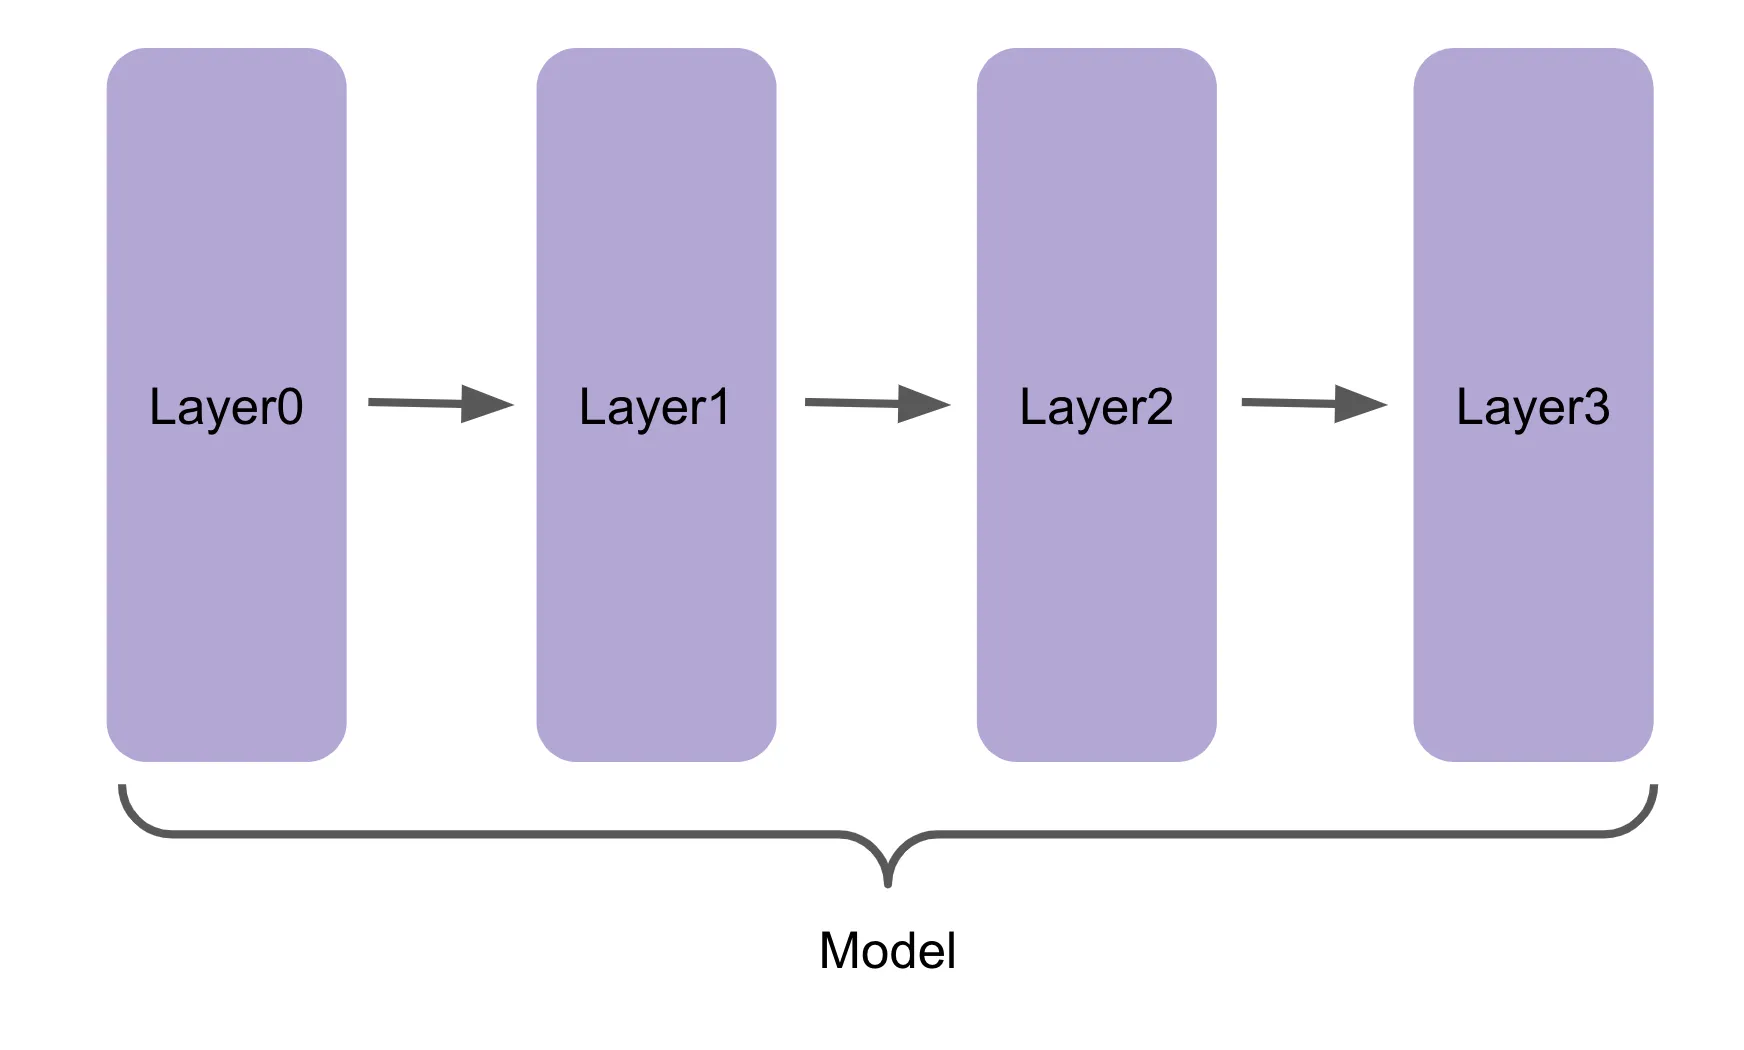

앞선 코드에서는 `nn.Module`을 상속받아 모델을 정의해 봤습니다. 레이어가 순차적으로 연결된 간단한 구조의 모델이었는데요. 즉, 모델에 입력된 텐서가 첫 번째 레이어에 들어가고, 이어지는 레이어들은 직전 레이어의 출력을 입력으로 받습니다(경우에 따라 중간에 활성화 함수가 적용될 수 있습니다). 그렇게 연산이 이어지다 마지막 레이어의 출력이 모델의 출력이 됩니다.

아래 코드에서는 모델에 입력된 텐서가 `self.linear0`을 통과하고 그 결과에 `self.relu` 활성화 함수를 적용했습니다. 이어서 그 결과가 `self.linear1`을 통과한 다음, 또 `self.relu` 활성화 함수를 통과했고요. 여기서 나온 텐서는 마지막으로 `self.linear2`를 통과하여 모델의 출력이 되죠.

In [71]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(8,4)
        self.l1 = nn.Linear(4,6)
        self.l2 = nn.Linear(6,3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l0(x))
        x = self.relu(self.l2(x))
        y = self.l2(x)
        
        return y

#### `nn.Sequential`로 모델 만들기

그런데 방금처럼 레이어들이 순차적으로 연결된 모델은 `nn.Sequential`을 이용해 더 간편하게 만들 수도 있습니다. 사용법은 간단해요. 순차적으로 연결할 레이어(또는 활성화 함수) 객체들을 하나하나 콤마로 구분해 `nn.Sequential()`의 입력으로 넣어 주면 됩니다.

`nn.Sequential` 객체에 텐서를 입력하면 각 레이어의 출력이 다음 레이어의 입력으로 자동으로 전달됩니다. 따로 `__init__()` 메소드와 `forward()` 메소드를 구현할 필요가 없어 코드가 간결해지죠.

실제로 아래 코드로 모델 객체를 만들면 위의 `MyModel` 클래스로 만든 모델 객체와 구조가 동일합니다.

In [72]:
model = nn.Sequential(
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,6),
    nn.ReLU(),
    nn.Linear(6,3)
)

In [73]:
x = torch.randn(2,8)
y = model(x)

print(y)

tensor([[-0.1237, -0.2118, -0.1659],
        [ 0.0068, -0.3076, -0.1055]], grad_fn=<AddmmBackward0>)


#### `nn.Sequential` 객체가 포함된 계층 구조

`nn.Sequential` 역시 `nn.Module`이 부모 클래스입니다. 따라서 `nn.Sequential` 객체도 모델 안에 포함될 수 있습니다. 예를 들어 아래처럼 `__init__()` 메소드에서 `nn.Sequential` 객체를 만들어 사용해도 됩니다.

In [74]:
class MyModelWithSequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,6),
            nn.ReLU(),
            nn.Linear(6,3)
        )
        self.layer = nn.Linear(3,4)

    def forward(self, x):
        x = self.block(x)
        y = self.layer(x)

        return y

#### 실습

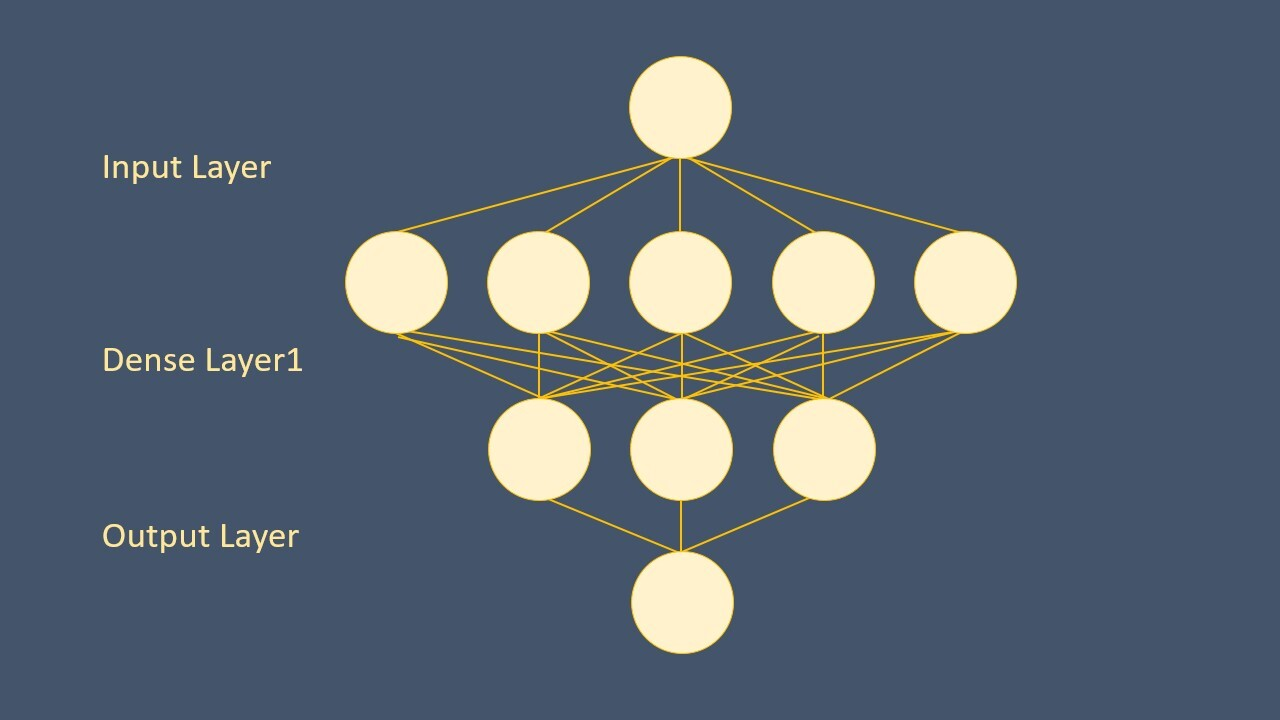

In [75]:
class MyModelWithSequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5,3),
            nn.ReLU(),
            nn.Linear(3,1)
        )

    def forward(self, x):
        y = self.block(x)
        return y

In [76]:
model = MyModelWithSequential()
y = model(torch.ones(1))
print(y)

tensor([-0.0951], grad_fn=<ViewBackward0>)


## 복잡한 모델 설계하기

입력과 출력이 여러 개이며, 병렬 구조를 포함하는 복잡한 모델을 설계하는 방법을 배웁니다. PyTorch의 `torch.nn.Module`을 활용하여 다양한 구조의 모델을 효율적으로 구현할 수 있습니다.

다음은 구현할 모델의 구조입니다.

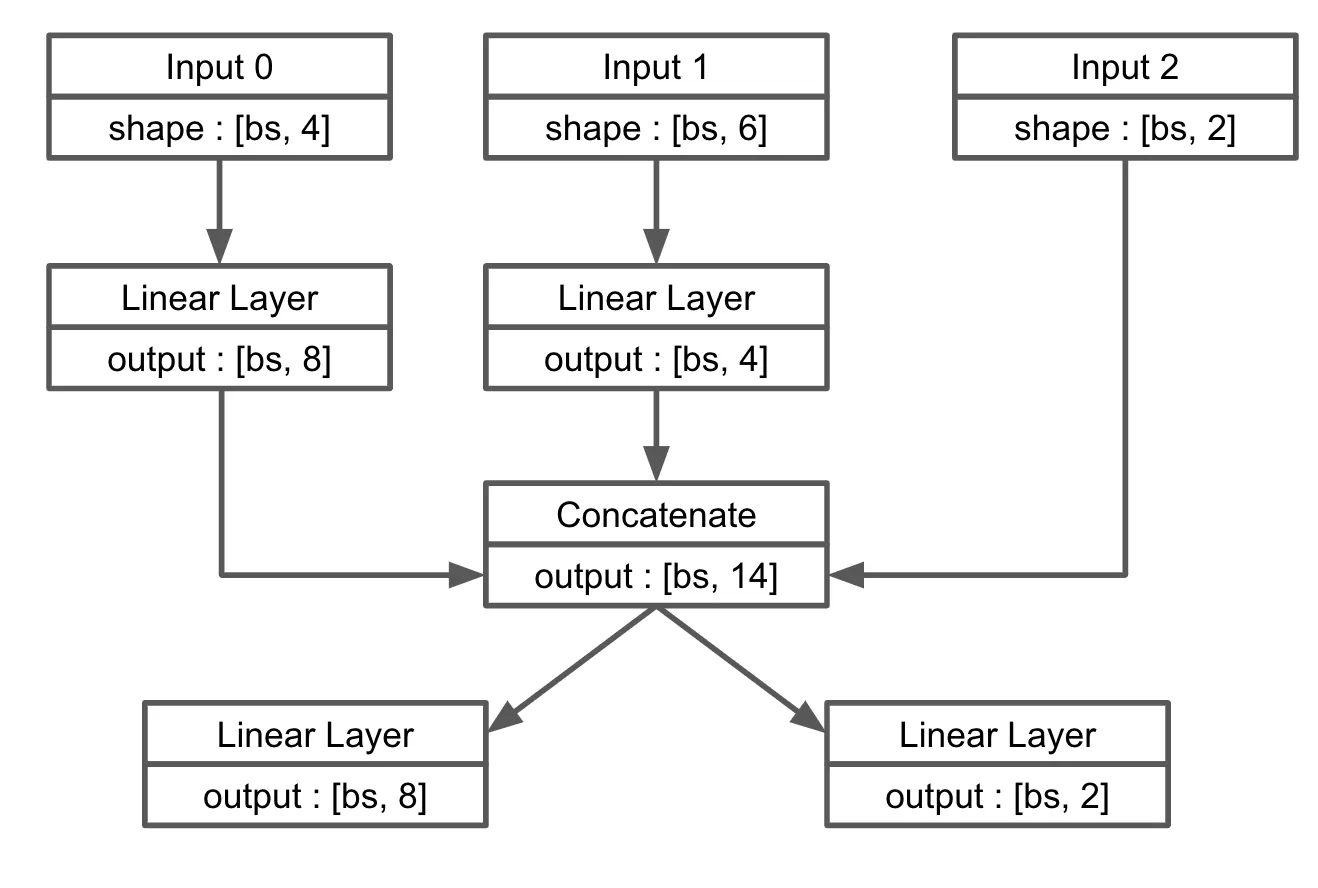

In [77]:
import torch
import torch.nn as nn

class ComplexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0_0 = nn.Linear(4,8)
        self.l0_1 = nn.Linear(6,4)
        self.l1_0 = nn.Linear(14,8)
        self.l1_1 = nn.Linear(14,2)
        self.relu = nn.ReLU()
    
    def forward(self, input0, input1, input2):
        # 첫번째
        h0_0 = self.relu(self.l0_0(input0))
        h0_1 = self.relu(self.l0_1(input1))
        
        # concat
        h1 = torch.cat([h0_0, h0_1, input2], dim=1)
        
        # output
        output0 = self.l1_0(h1) 
        output1 = self.l1_1(h1)
        
        return output0, output1

In [78]:
model = ComplexModel()
batch_size = 2

x0 = torch.randn(batch_size, 4)
x1 = torch.randn(batch_size, 6)
x2 = torch.randn(batch_size, 2)

In [79]:
y0, y1 = model(x0,x1,x2)
print(y0)
print(y1)

tensor([[-0.4967,  0.4387,  0.1619, -0.0175, -0.2780, -0.4755,  0.4736,  0.4421],
        [-0.4341,  0.9929,  0.3197, -0.1500, -0.8148, -0.1781,  0.2716,  0.6824]],
       grad_fn=<AddmmBackward0>)
tensor([[0.1278, 0.2767],
        [0.1278, 0.5302]], grad_fn=<AddmmBackward0>)


1. **병렬 레이어**
    - `input0`은 `Linear(4, 8)`로 처리 → 출력 크기: `[batch, 8]`
    - `input1`은 `Linear(6, 4)`로 처리 → 출력 크기: `[batch, 4]`
2. **컨캐터네이트**
    - `[batch, 8]` + `[batch, 4]` + `[batch, 2]` → `[batch, 14]`
3. **출력 레이어**
    - `[batch, 14]` → `Linear(14, 8)` → `output0` 크기: `[batch, 8]`
    - `[batch, 14]` → `Linear(14, 2)` → `output1` 크기: `[batch, 2]`

#### 실습

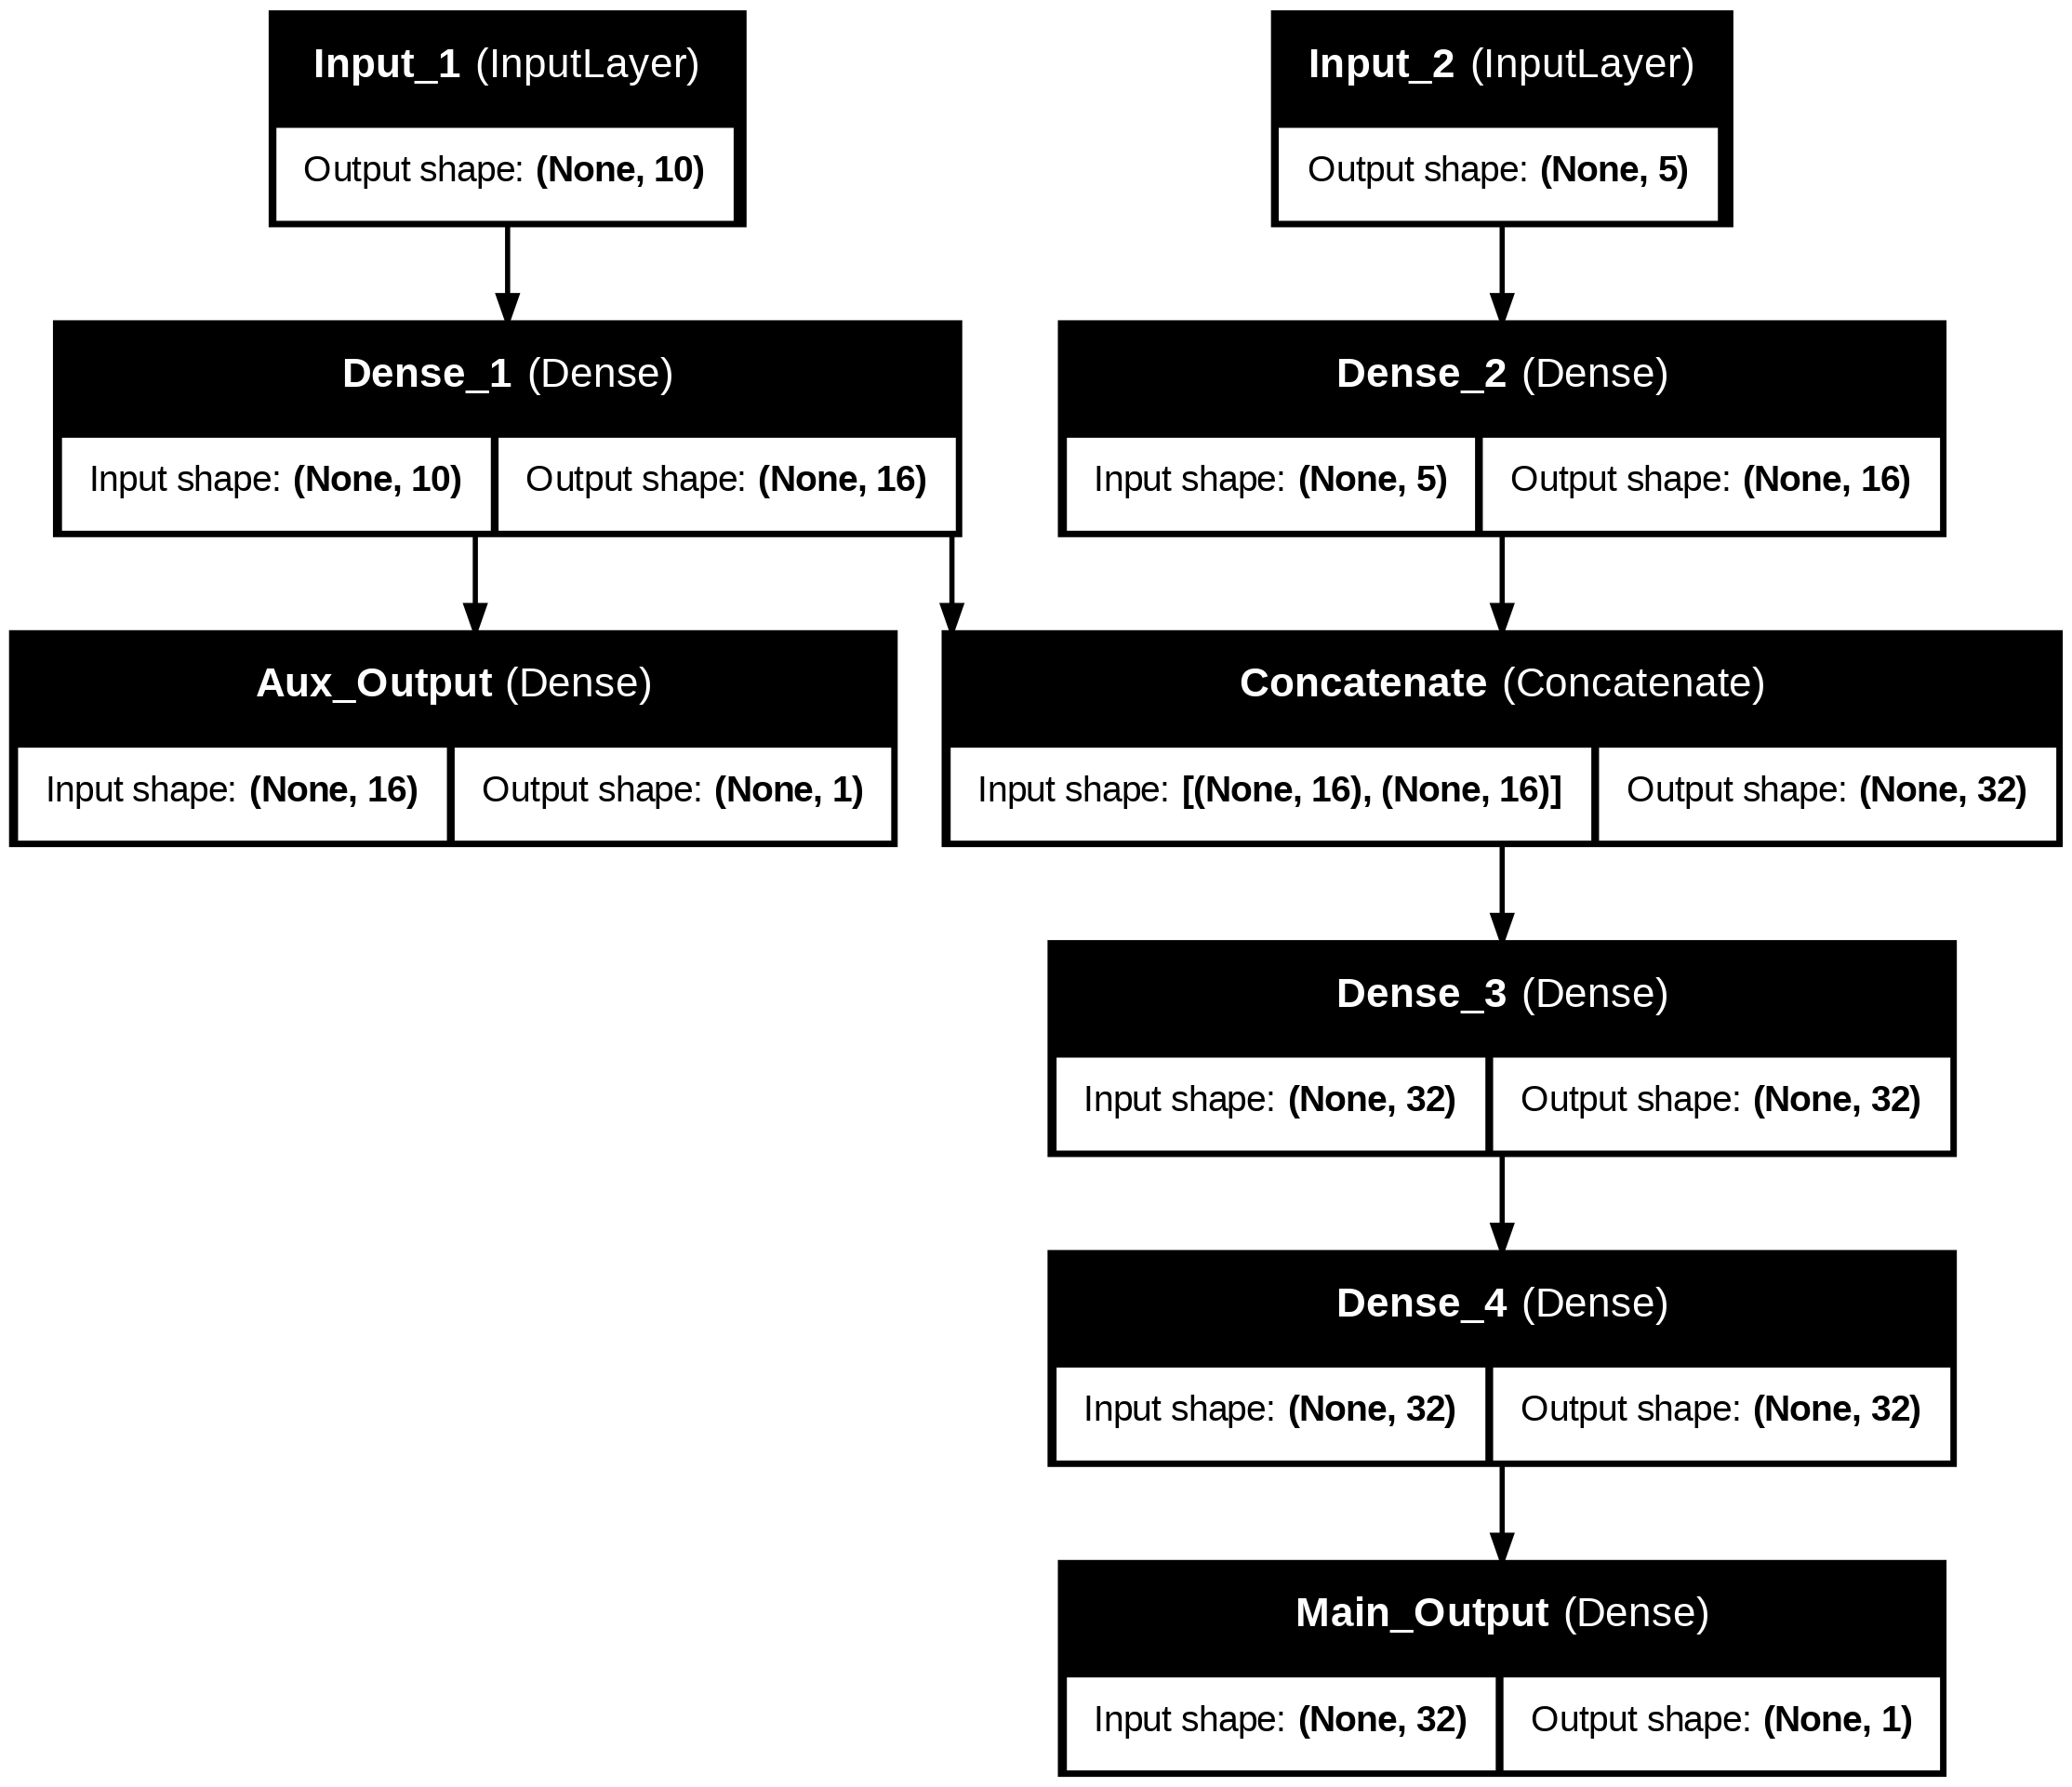

In [80]:
# Input_1 (10차원) ───> Dense_1 (16차원) ────────────┐
#                                                   │
#                                                   ├─> Concatenate ──> Dense_3 (32차원) ──> Dense_4 (32차원) ──> Main_Output (1차원)
# Input_2 (5차원) ───> Dense_2 (16차원) ────────────┘
#                                                   └────────────> Aux_Output (1차원)


In [81]:
class ComplexModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense_1 = nn.Linear(10,16)
        self.Dense_2 = nn.Linear(5,16)
        self.Dense_3 = nn.Linear(32,32)
        self.Dense_4 = nn.Linear(32,32)
        
        self.relu = nn.ReLU()
        
        self.Aux_Output = nn.Linear(16,1)
        self.Main_Output = nn.Linear(32,1)
        
    def forward(self, input1, input2):
        x1 = self.relu(self.Dense_1(input1))
        aux_out = self.Aux_Output(x1)
        
        x2 = self.relu(self.Dense_2(input2))
        x2 = torch.cat([x1,x2], dim=1)
        x2 = self.relu(self.Dense_3(x2))
        x2 = self.relu(self.Dense_4(x2))
        main_out = self.Main_Output(x2)
        
        return aux_out, main_out

In [82]:
model = ComplexModel2()
input1 = torch.ones((1,10))
input2 = torch.ones((1,5))
out1, out2 = model(input1, input2)

In [83]:
out1, out2

(tensor([[-0.5383]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1067]], grad_fn=<AddmmBackward0>))

## 모델 정보 확인하기

PyTorch 모델에 담긴 다양한 정보를 확인하는 방법을 살펴봅니다. 모델 구조, 레이어 정보, 파라미터 등을 확인하여 모델 디버깅과 분석에 활용할 수 있습니다.

In [84]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(8,4)
        self.l1 = nn.Linear(4,6)
        self.l2 = nn.Linear(6,3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l0(x))
        x = self.relu(self.l2(x))
        y = self.l2(x)
        
        return y
    
model = MyModel()

#### 레이어 정보 확인

In [85]:
# 모델 전체 구조 출력
print(model)

MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
)


In [86]:
# 서브 모듈 확인
list(model.children())

[Linear(in_features=8, out_features=4, bias=True),
 Linear(in_features=4, out_features=6, bias=True),
 Linear(in_features=6, out_features=3, bias=True),
 ReLU()]

In [87]:
# 서브모듈 이름과 함께 출력
for named_child in model.named_children():
    print(named_child)

('l0', Linear(in_features=8, out_features=4, bias=True))
('l1', Linear(in_features=4, out_features=6, bias=True))
('l2', Linear(in_features=6, out_features=3, bias=True))
('relu', ReLU())


In [88]:
# 파라미터 정보 확인
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0113, -0.2447,  0.3286,  0.1962, -0.0566,  0.2928, -0.0359,  0.3169],
        [ 0.0171, -0.1651,  0.0791,  0.1464, -0.3494,  0.2095, -0.2475,  0.1435],
        [-0.2750, -0.3030,  0.1858, -0.0910,  0.0239, -0.1642, -0.0144,  0.0465],
        [ 0.3023,  0.0042, -0.2725,  0.2535, -0.1888, -0.0641,  0.1243, -0.3273]],
       requires_grad=True)
Parameter containing:
tensor([-0.1667,  0.0560, -0.3460, -0.0638], requires_grad=True)
Parameter containing:
tensor([[-0.2703,  0.4481,  0.0063,  0.3540],
        [-0.0890, -0.0166, -0.4070,  0.2910],
        [ 0.3870, -0.1455,  0.1504,  0.3784],
        [-0.1751, -0.3120, -0.2234, -0.3423],
        [-0.4482,  0.4819, -0.2255, -0.0626],
        [ 0.3673,  0.4332,  0.4291, -0.0392]], requires_grad=True)
Parameter containing:
tensor([-0.2073, -0.0019,  0.1969, -0.0446, -0.0135, -0.3957],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1704,  0.2474, -0.1220,  0.1817,  0.0181, -0.2492],
        [ 0.2222, 

각 레이어의 웨이트(weight)와 바이어스(bias) 텐서 값 출력.

In [89]:
# 파라미터 이름과 함께 확인
for named_param in model.named_parameters():
    print(named_param)

('l0.weight', Parameter containing:
tensor([[ 0.0113, -0.2447,  0.3286,  0.1962, -0.0566,  0.2928, -0.0359,  0.3169],
        [ 0.0171, -0.1651,  0.0791,  0.1464, -0.3494,  0.2095, -0.2475,  0.1435],
        [-0.2750, -0.3030,  0.1858, -0.0910,  0.0239, -0.1642, -0.0144,  0.0465],
        [ 0.3023,  0.0042, -0.2725,  0.2535, -0.1888, -0.0641,  0.1243, -0.3273]],
       requires_grad=True))
('l0.bias', Parameter containing:
tensor([-0.1667,  0.0560, -0.3460, -0.0638], requires_grad=True))
('l1.weight', Parameter containing:
tensor([[-0.2703,  0.4481,  0.0063,  0.3540],
        [-0.0890, -0.0166, -0.4070,  0.2910],
        [ 0.3870, -0.1455,  0.1504,  0.3784],
        [-0.1751, -0.3120, -0.2234, -0.3423],
        [-0.4482,  0.4819, -0.2255, -0.0626],
        [ 0.3673,  0.4332,  0.4291, -0.0392]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([-0.2073, -0.0019,  0.1969, -0.0446, -0.0135, -0.3957],
       requires_grad=True))
('l2.weight', Parameter containing:
tensor([[ 0.

#### 모델이 포함된 모델

In [90]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = MyModel()
        self.linear = nn.Linear(3,4)

    def forward(self, x):
        x = self.block(x)
        return self.linear(x)

model2 = MyModel2()

MyModel2는 MyModel을 서브모듈로 포함한 모델입니다.

In [91]:
# 모델 전체 구조 출력
print(model2)

MyModel2(
  (block): MyModel(
    (l0): Linear(in_features=8, out_features=4, bias=True)
    (l1): Linear(in_features=4, out_features=6, bias=True)
    (l2): Linear(in_features=6, out_features=3, bias=True)
    (relu): ReLU()
  )
  (linear): Linear(in_features=3, out_features=4, bias=True)
)


In [92]:
# named sub module 확인
for named_child in model2.named_children():
    print(named_child)

('block', MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
))
('linear', Linear(in_features=3, out_features=4, bias=True))


In [93]:
# 중첩된 모델의 파라미터 확인
for named_param in model2.named_parameters():
    print(named_param)

('block.l0.weight', Parameter containing:
tensor([[-0.2570, -0.2384, -0.0704,  0.1047, -0.0582,  0.2931,  0.2957,  0.0064],
        [ 0.0751,  0.2511, -0.0441,  0.1379, -0.0934,  0.2209, -0.0437, -0.0948],
        [ 0.0119,  0.2920,  0.0798,  0.3010, -0.2822,  0.2053,  0.0117,  0.2659],
        [ 0.1162, -0.2938,  0.3380, -0.1684,  0.2707,  0.3333, -0.3229,  0.1570]],
       requires_grad=True))
('block.l0.bias', Parameter containing:
tensor([-0.1846,  0.1653,  0.1918, -0.2593], requires_grad=True))
('block.l1.weight', Parameter containing:
tensor([[-0.0373, -0.0274, -0.4307, -0.3363],
        [-0.4280,  0.4623, -0.3009,  0.3973],
        [-0.4310,  0.3165,  0.1349, -0.1824],
        [ 0.4264, -0.1624,  0.1061,  0.2156],
        [ 0.2847, -0.1791,  0.1580, -0.4721],
        [ 0.2163,  0.0211,  0.1618,  0.2302]], requires_grad=True))
('block.l1.bias', Parameter containing:
tensor([0.2670, 0.1276, 0.4841, 0.2524, 0.0537, 0.4632], requires_grad=True))
('block.l2.weight', Parameter contain

## 회귀모델 만들기 실습

California Housing 데이터는 입력 피처가 8가지이고 타깃은 주택 가격 1가지입니다. 따라서 California Housing 데이터로 집값 예측 문제를 푼다면 모델의 입력 차원과 출력 차원은 각각 8과 1이 되어야 합니다.

이를 반영하여 아래 표에 모델 구조를 정리해 두었어요. 세 레이어는 순차적으로 이어집니다. 표에 나온 대로 `CaliforniaHousingModel` 클래스를 정의해 주세요.

| index | 0 | 1 | 2 |
| --- | --- | --- | --- |
| 레이어 타입 | Linear | Linear | Linear |
| 입력 차원 | 8 | 16 | 32 |
| 출력 차원 | 16 | 32 | 1 |
| 활성화 함수 | ReLU | ReLU | - |

### 실습 결과

코드 마지막 부분에서 `children()` 메소드 결과를 출력했을 때, 다음과 같이 `Linear` 레이어 3개와 `ReLU` 활성화 함수 1개가 나오면 됩니다.

### 힌트



- 힌트 1
    
    PyTorch에서 모델 클래스를 정의할 때는 `nn.Module` 클래스를 상속받아야 합니다.
    
- 힌트 2
    
    `__init__()` 메소드에서는 부모 클래스의 `__init()__` 메소드를 호출해 준 뒤, 모델에 필요한 레이어나 활성화 함수 등을 정의해야 합니다.
    
- 힌트 3
    
    `forward()` 메소드에서는 모델의 순전파 연산을 구현해야 합니다.

### 코드

In [94]:
import torch
import torch.nn as nn

class CaliforniaHousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 여기에 코드를 작성하세요.
        self.linear0 = nn.Linear(8,16)
        self.linear1 = nn.Linear(16,32)
        self.linear2 = nn.Linear(32,1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # 여기에 코드를 작성하세요.
        x = self.relu(self.linear0(x))
        x = self.relu(self.linear1(x))
        output = self.linear2(x)
        
        return output

model = CaliforniaHousingModel()
for child in model.children():
        print(child)

Linear(in_features=8, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)
ReLU()


## 모델과 연산장치

앞서 텐서에 대해 배울 때 텐서의 연산 장치를 어떻게 지정할 수 있는지 배웠습니다. 따로 설정하지 않으면 텐서는 기본적으로 CPU에 만들어지는데요. to() 메소드로 텐서를 CPU에서 GPU로, 또는 GPU에서 CPU로 옮길 수 있었죠. 장치 설정은 'cpu'나 'cuda'처럼 문자열을 사용해도 됐고, torch.device 객체를 만들어 사용하는 것도 가능했습니다. 텐서끼리 연산을 하려면 모든 텐서가 동일한 연산 장치를 사용해야 한다는 것도 배웠어요.

#### PyTorch에서 기본 장치는 CPU

PyTorch에서는 텐서뿐만 아니라 모델도 어떤 장치에서 사용할지 설정할 수 있습니다. 일단 텐서와 마찬가지로 모델도 기본적으로 CPU에 만들어져요.

In [95]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(8,4)
        self.l1 = nn.Linear(4,6)
        self.l2 = nn.Linear(6,3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.l0(x))
        x = self.relu(self.l1(x))
        y = self.l2(x)

        return y

model = MyModel()

In [96]:
model = MyModel()
print(model)

MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
)


그런데 모델이 CPU에 있는지 GPU에 있는지를 모델 객체에서 바로 확인할 수는 없습니다. 부모 클래스인 nn.Module 클래스에 device 속성이 따로 없기 때문이에요. 그 대신 모델의 파라미터 텐서에서 device 속성을 확인해 보면 됩니다.

In [97]:
for name, param in model.named_parameters():
    print(f'{name} : {param.device}')

l0.weight : cpu
l0.bias : cpu
l1.weight : cpu
l1.bias : cpu
l2.weight : cpu
l2.bias : cpu


결과를 보면 모든 파라미터 텐서가 CPU에 있다고 나옵니다. 즉, 모델이 CPU에 있다고 할 수 있는 거죠.

#### CPU에 있는 모델을 GPU로 옮기기

CPU에 있는 모델을 GPU로 옮기려면, 텐서를 GPU로 옮길 때처럼 to() 메소드에 'cuda'를 입력하면 돼요. 모델에서 to() 메소드를 쓸 때는 결과를 따로 변수에 할당하지 않을 때가 많습니다. 아래처럼만 작성해서 실행해도 모델이 GPU로 옮겨져요.

In [98]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to('cuda')
# model.to(device)

MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
)

In [99]:
for name, param in model.named_parameters():
    print(f'{name} : {param.device}')

l0.weight : cuda:0
l0.bias : cuda:0
l1.weight : cuda:0
l1.bias : cuda:0
l2.weight : cuda:0
l2.bias : cuda:0


다시 파라미터 텐서들의 device 속성을 프린트해 보면 아래처럼 나올 거예요. 여기서 숫자 0은 모델이 0번 인덱스 GPU에 있다는 뜻입니다.

`to()` 메소드 대신 `cuda()` 메소드를 사용할 수도 있습니다.

In [100]:
model.cpu()

MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
)

In [101]:
for name, param in model.named_parameters():
    print(f"{name} : {param.device}")

l0.weight : cpu
l0.bias : cpu
l1.weight : cpu
l1.bias : cpu
l2.weight : cpu
l2.bias : cpu


In [102]:
model.cuda()

MyModel(
  (l0): Linear(in_features=8, out_features=4, bias=True)
  (l1): Linear(in_features=4, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=3, bias=True)
  (relu): ReLU()
)

In [103]:
for name, param in model.named_parameters():
    print(f"{name} : {param.device}")

l0.weight : cuda:0
l0.bias : cuda:0
l1.weight : cuda:0
l1.bias : cuda:0
l2.weight : cuda:0
l2.bias : cuda:0


#### 텐서의 연산 장치와 모델의 연산 장치

모델에 텐서를 입력하면 입력된 텐서와 모델 파라미터 텐서가 여러 연산을 수행하게 됩니다. 그런데 텐서 간 연산이 이루어지려면 모든 텐서가 같은 연산 장치에 있어야 한다고 했죠. 따라서 모델에 텐서를 입력할 때도 입력 텐서와 모델이 동일한 장치에 있어야 정상적으로 연산이 가능합니다.

아래 코드처럼 모델을 GPU로 옮기고, 이어서 CPU에 있는 텐서를 모델에 입력해 보겠습니다

In [104]:
# model.to('cuda')
# tensor_cpu = torch.randn(2,8)  # 다른 장치에 있기 때문에 오류!
# model(tensor_cpu)

그러면 이렇게 오류가 납니다. 모델 파라미터 텐서는 GPU에 있는 반면, 모델에 입력된 텐서는 CPU에 있어서 텐서 간 연산이 불가능하다는 거죠.

In [105]:
model.to('cuda')
tensor_gpu = torch.randn(2,8).to('cuda')
model(tensor_gpu)

tensor([[-0.2831, -0.2487, -0.2326],
        [-0.2831, -0.2483, -0.2321]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

만약 GPU 여러 대를 사용하는 경우에는 텐서와 모델이 동일한 GPU에 있어야 연산이 가능합니다. to() 메소드를 사용할 때 GPU 인덱스까지 확실히 동일하게 지정해 줘야 해요.

In [106]:
model.to('cuda:0')
tensor_gpu = torch.randn(2,8).to('cuda:0')
model(tensor_gpu)

tensor([[-0.2788, -0.1880, -0.1693],
        [-0.3035, -0.3004, -0.2665]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# 모델 학습시키기

##  Training Loop 이해하기

PyTorch를 사용하여 전복(abalone) 데이터를 기반으로 회귀 문제를 푸는 과정을 살펴보겠습니다. 이 교안에서는 데이터 준비, 모델 생성, 그리고 학습 루프의 뼈대를 설명합니다.

In [107]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [108]:
# 데이터 불러오기
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)


input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

class AbaloneDataset(Dataset):
    def __init__ (self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index], dtype=torch.float32)
        target_tensor = torch.tensor(self.target_data[index], dtype=torch.float32)
        return input_tensor, target_tensor

train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size: train_size + val_size]
val_targets = target_data[train_size: train_size + val_size]

test_inputs = input_data[train_size + val_size : ]
test_targets = target_data[train_size + val_size : ]

scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [109]:
# 모델 클래스 정의
class AbaloneModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = AbaloneModel()

### 모델 설명

- **구조**: Fully Connected Layers로 구성.
    - 첫 레이어는 입력 피처 7개, 출력 32개.
    - 마지막 레이어는 출력 1개로, 나이를 예측.
- **활성화 함수**: ReLU 활성화 함수 사용.
- **출력**: 회귀 문제에 적합하게 마지막 레이어에서는 활성화 함수를 적용하지 않음.

### 트레이닝 루프

#### 뼈대 구성

트레이닝 루프의 기본 구조는 다음과 같습니다.

```python
epochs = 10
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train)
        # pred와 y_train 사이에서 loss 계산
        # loss.backward()로 gradient 계산
        # optimizer.step()으로 모델 파라미터 업데이트

```

#### 설명:

1. **데이터 루프**:
    - `train_dataloader`에서 배치를 하나씩 가져옵니다.
2. **에폭 루프**:
    - 데이터 전체를 반복 학습하기 위해 에폭 루프를 추가합니다.
3. **예측 및 업데이트**:
    - 예측값(`pred`)과 실제값(`y_train`)으로 손실 계산.
    - 손실 기반으로 모델 파라미터 업데이트.

In [110]:
epochs = 10
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train)
        # pred와 y_train 사이에서 loss 계산

        # loss.backward()로 gradient 계산

        # optimizer.step()으로 모델 파라미터 업데이트

## Loss 계산하기

### MSE 손실 함수

전복 데이터는 회귀 문제이므로 평균제곱오차(MSE, Mean Squared Error)를 손실 함수로 사용합니다.

In [111]:
loss_fn = nn.MSELoss()

이제 트레이닝 루프에 로스 계산을 추가해 보겠습니다.

In [112]:
epochs = 10
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train)
        # pred와 y_train 사이에서 loss 계산
        loss = loss_fn(pred, y_train)
        # loss.backward()로 gradient 계산

        # optimizer.step()으로 모델 파라미터 업데이트

c:\Users\amy\Desktop\sprint\sprint-ai07\venv_ml\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### 코드 설명

1. **예측값 계산**: `pred = model(x_train)`
    - 입력 데이터를 모델에 통과시켜 예측값을 계산합니다.
2. **손실 값 계산**: `loss = loss_fn(pred, y_train)`
    - MSE 손실 함수 객체에 모델 예측값과 실제 타깃값을 넣어 손실 값을 계산합니다.
    - *예측값(pred)와 타깃값(y_train)의 순서를 바꾸지 않도록 주의*해야 합니다.

In [113]:
# 로스 값 출력
epochs = 1
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train)
        loss = loss_fn(pred, y_train)
        print(loss)
        print(pred[0].item(), y_train[0].item())
        break


tensor(110.3634, grad_fn=<MseLossBackward0>)
0.03624282032251358 6.0


- 예측값 텐서(`pred`)는 크기가 `(32, 1)`이고, 타깃값 텐서(`y_train`)는 크기가 `(32)`입니다.
- 두 텐서의 크기가 다르면 PyTorch가 브로드캐스팅을 수행하며, 이로 인해 경고 메시지가 표시됩니다.

예측값 텐서에서 불필요한 차원을 제거하기 위해 squeeze() 메서드를 사용합니다.

In [114]:
# 로스 값 출력
epochs = 1
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train).squeeze()
        loss = loss_fn(pred, y_train)
        print(loss)
        print(pred[0].item(), y_train[0].item())
        break

tensor(115.8923, grad_fn=<MseLossBackward0>)
0.019400734454393387 9.0


경고 메시지가 사라지고, 정상적으로 손실 값이 출력됩니다.

#### 다른 오차 함수

In [115]:
# 평균 제곱 오차(Mean Squared Error, MSE)
inputs = torch.tensor([[2.0, 2.0, 2.0]])
targets = torch.tensor([[0.0, 0.0, 1.0]])

loss_fn = nn.MSELoss()
loss = loss_fn(inputs, targets)
loss

tensor(3.)

In [116]:
# 크로스 엔트로피(Cross Entropy)
inputs = torch.tensor([[2.0, 2.0, 2.0]])
targets = torch.tensor([[0.0, 0.0, 1.0]])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(inputs, targets)
loss

tensor(1.0986)

크로스 엔트로피는 분류 문제에서 사용되는 손실 함수입니다. 모델이 예측한 클래스 분류 확률과 실제 타깃이 얼마나 다른지를 측정하죠. `nn`에서는 `CrossEntropyLoss` 객체를 만들어 사용하면 됩니다.

분류 모델은 마지막에 softmax 활성화 함수를 적용하면 확률을 출력하고, 그러지 않으면 확률로 바꾸지 않은 원본 값인 로짓(logit)을 출력하는데요. `nn.CrossEntropyLoss`는 예측 값으로 로짓을 입력받도록 되어 있습니다. 즉, 모델의 `forward()` 메소드를 정의할 때, 마지막에는 따로 활성화 함수를 적용하지 않고 텐서를 그대로 출력하면 됩니다.

그리고 정답 레이블은 정수 인덱스로 나타내야 합니다. One-hot 인코딩된 형태로 표현하면 안 된다는 점 주의해 주세요.

아래 코드는 클래스 개수가 세 개인 분류 문제에서, 배치 크기가 4인 데이터에 대해 크로스 엔트로피 값을 구하는 가상의 코드입니다.


In [117]:
# 이진 크로스 엔트로피(Binary Cross Entropy)
inputs = torch.randn(4)
targets = torch.tensor([1.,1.,0.,0.])

loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(inputs, targets)
print(loss)

tensor(0.6330)


이진 크로스 엔트로피는 클래스가 두 개인 이진 분류에서 사용하는 손실 함수입니다. 영어 표현의 첫 글자를 따 BCE라고 부르기도 해요. `nn`에서는 `BCEWithLogitsLoss` 객체로 사용할 수 있습니다.

이진 분류 모델은 마지막에 sigmoid 활성화 함수를 적용하면 확률을 출력하고, 그러지 않으면 원본 값인 로짓을 출력합니다. `nn.BCEWithLogitsLoss`는 이름에서 짐작할 수 있듯이 예측 값으로 로짓을 입력받도록 되어 있어요. 따라서 모델의 `forward()` 메소드를 정의할 때, 마지막에 sigmoid 함수를 쓰지 않고 텐서를 그대로 출력시키면 됩니다.

정답 레이블은 인덱스로 나타내야 합니다. 이진 분류니까 0 또는 1로만 표현해야 한다는 뜻이죠. 주의할 점은 타깃 텐서가 정수형이 아니라 실수형 텐서여야 한다는 겁니다.


## Gradient 계산하기

딥러닝에서 **백프로퍼게이션**(back propagation, 역전파)을 사용하여 그래디언트를 계산합니다. 백프로퍼게이션은 **순전파**(forward propagation) 동안 수행된 연산 기록을 바탕으로 그래디언트를 구합니다.

이 과정에서 PyTorch는 **자동 미분**(autograd)을 통해 그래디언트를 자동으로 계산합니다.

#### `requires_grad` 속성

PyTorch에서 텐서를 생성할 때 requires_grad 속성을 설정하면 해당 텐서와 관련된 연산이 기록됩니다.

In [118]:
# requires_grad=True로 설정하면, 이후 연산이 기록되고, 그래디언트를 계산할 수 있습니다.
x = torch.tensor([2.0], requires_grad=True)
x.requires_grad

True

In [119]:
y = torch.tensor([3.0])
y.requires_grad

False

In [120]:
# 이미 생성된 텐서의 requires_grad 변경
y.requires_grad_()

tensor([3.], requires_grad=True)

In [121]:
x.requires_grad_(False)
x.requires_grad

False

In [122]:
##### 순전파 ######
x = torch.tensor([2.0], requires_grad=True)
y = x ** 3
print(y)
#################

##### 역전파 ######
y.backward()
print(x.grad)
#################

tensor([8.], grad_fn=<PowBackward0>)
tensor([12.])


In [123]:
##### 순전파 ######


#################

##### 역전파 ######


#################

만약 requires_grad=False라면 연산 기록이 생성되지 않아 그래디언트를 계산할 수 없습니다.

#### 트레이닝 루프에서 그래디언트 계산

트레이닝 루프에서 손실 값을 기반으로 그래디언트를 계산하려면 **loss.backward()** 를 호출합니다|.

In [124]:
epochs = 1
for epoch in range(epochs):
    for train_batch in train_dataloader:
        x_train, y_train = train_batch
        pred = model(x_train).squeeze()
        loss = loss_fn(pred, y_train)
        loss.backward()  # 그래디언트 계산
        break

##### 주요 사항

- 손실 텐서(`loss`)는 **`grad_fn`** 속성을 포함하고 있어야 합니다.
- 모델 파라미터의 `requires_grad` 속성은 `True`로 설정되어 있어야 합니다.

In [125]:
# 모델의 파라미터와 requires_grad 상태를 확인할 수 있습니다.
for name,param in model.named_parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True


In [126]:
# 그래디언트 계산 후, 모델 파라미터의 grad 속성에서 결과를 확인할 수 있습니다.
for name, param in model.named_parameters():
    print(f"{name} : {param.grad}")

fc1.weight : tensor([[-0.0014, -0.0013, -0.0009, -0.0008, -0.0005, -0.0008, -0.0009],
        [ 0.0538,  0.0539,  0.0414,  0.0542,  0.0532,  0.0520,  0.0546],
        [-0.0564, -0.0633, -0.0498, -0.0563, -0.0547, -0.0563, -0.0519],
        [ 0.0213,  0.0228,  0.0197,  0.0319,  0.0343,  0.0307,  0.0263],
        [-0.0592, -0.0645, -0.0563, -0.0558, -0.0583, -0.0513, -0.0480],
        [ 0.0248,  0.0273,  0.0184,  0.0230,  0.0190,  0.0226,  0.0245],
        [-0.0050, -0.0046, -0.0037, -0.0043, -0.0043, -0.0039, -0.0042],
        [ 0.0077,  0.0060,  0.0216,  0.0020,  0.0023, -0.0009,  0.0029],
        [-0.0172, -0.0186, -0.0171, -0.0177, -0.0164, -0.0196, -0.0167],
        [-0.0021, -0.0053,  0.0042, -0.0043, -0.0013, -0.0018, -0.0090],
        [-0.1010, -0.1092, -0.0836, -0.0994, -0.0997, -0.0965, -0.0888],
        [ 0.0420,  0.0472,  0.0313,  0.0301,  0.0356,  0.0251,  0.0209],
        [-0.0247, -0.0278, -0.0229, -0.0243, -0.0240, -0.0233, -0.0220],
        [ 0.0043,  0.0033,  0.0010,  0

PyTorch의 자동 미분 기능(autograd)은 다음과 같은 장점을 제공합니다:

1. **자동화**: 복잡한 네트워크에서도 그래디언트를 자동으로 계산.
2. **유연성**: 텐서와 연산이 동적으로 정의되므로 다양한 연산 구조를 지원.
3. **단순화**: 사용자 정의 손실 함수나 연산에도 동일한 방법 적용 가능.

## Gradient 계산이 필요하지 않을 때

#### 1. Gradient 계산 비활성화가 필요한 이유

PyTorch는 **자동 미분(autograd)** 기능을 사용하여 순전파 연산 정보를 기록하고 역전파로 gradient를 계산합니다. 그러나 gradient 계산이 필요 없는 상황에서도 연산 정보를 기록하면 불필요한 자원을 소모하게 됩니다. 이를 방지하기 위해 **연산 기록 비활성화** 방법을 활용합니다.

#### 기본 개념

PyTorch에서 텐서를 생성할 때 `requires_grad` 속성을 설정하면 gradient 계산 여부를 제어할 수 있습니다.

- 기본적으로 `requires_grad=False`입니다.
- 연산 기록이 필요 없으면 `requires_grad=False`로 설정하여 비활성화합니다.

In [127]:
# 1. 텐서 생성 시 설정
x1 = torch.tensor([2.0])  # 기본값: requires_grad=False
x2 = torch.tensor([2.0], requires_grad=False)  # 명시적 설정

print(x1.requires_grad)  # False
print(x2.requires_grad)  # False

False
False


In [128]:
# 2. 기존 텐서의 속성 변경
x3 = torch.tensor([2.0], requires_grad=True)
print(x3.requires_grad)  # True

x3.requires_grad_(False)
print(x3.requires_grad)  # False

True
False


- 특정 모델 파라미터를 **고정**하려는 경우.
- 학습 과정에서 일부 텐서가 업데이트되지 않아야 할 때.

In [129]:
# 3. torch.no_grad() 활용

'''

`torch.no_grad()`는 일시적으로 gradient 계산과 연산 기록을 비활성화합니다.

주로 평가(validation) 또는 추론(inference) 과정에서 사용됩니다.

torch.no_grad()는 with 블록 내부에서만 작동하며, 블록 종료 후 자동으로 연산 기록이 재활성화됩니다.

'''

x = torch.tensor([2.0], requires_grad=True)

# 연산 기록이 활성화된 경우
y1 = x ** 3
print(y1)  # tensor([8.], grad_fn=<PowBackward0>)

# torch.no_grad()로 연산 기록 비활성화
with torch.no_grad():
    y2 = x ** 3
print(y2)
# 블록 종료 후 연산 기록 재활성화

tensor([8.], grad_fn=<PowBackward0>)
tensor([8.])


#### 4. `requires_grad` vs `torch.no_grad()`

| **특징** | **`requires_grad=False`** | **`torch.no_grad()`** |
| --- | --- | --- |
| **사용 목적** | 영구적으로 gradient 계산 비활성화 | 일시적으로 gradient 계산 비활성화 |
| **적용 범위** | 특정 텐서 | 블록 내 모든 연산 |
| **주요 사용 사례** | 모델의 일부 파라미터 고정 | 평가 및 추론 |
| **재활성화 필요 여부** | 텐서 속성 수정 필요 | 블록 종료 후 자동 재활성화 |

## Optimizer와 파라미터 업데이트

#### Optimizer 개념

PyTorch는 다양한 최적화 알고리즘을 제공하며, 이를 Optimizer 객체로 관리합니다. Optimizer는 자동 미분으로 계산된 그래디언트를 활용하여 모델 파라미터를 업데이트합니다.

In [130]:
import torch.optim as optim

#### SGD 옵티마이저 예제

1. **기본 생성**
    
    가장 간단한 옵티마이저인 SGD를 생성합니다.
    
    ```python
    optimizer = optim.SGD(model.parameters())
    
    ```
    
    - `model.parameters()`: 모델의 파라미터를 가져옵니다.
2. **하이퍼파라미터 설정**
    
    옵티마이저의 하이퍼파라미터를 지정할 수 있습니다. 예를 들어, 학습률(`lr`)과 모멘텀(`momentum`)을 설정합니다.
    
    ```python
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    ```

#### Optimizer로 파라미터 업데이트

1. 파라미터 업데이트

    Optimizer의 **`step()`** 메소드를 호출하면, 계산된 그래디언트를 바탕으로 모델 파라미터가 업데이트됩니다.

    ```python
    optimizer.step()

    ```

2. 그래디언트 초기화

    Optimizer의 **`zero_grad()`** 메소드를 호출해 기존 그래디언트를 초기화합니다.

    PyTorch에서는 그래디언트가 **누적**되므로, 각 배치 처리 후 초기화가 필요합니다.

    ```python
    optimizer.zero_grad()

    ```

트레이닝 루프 실행 후, 전복 데이터를 기반으로 한 회귀 모델이 10 에폭 동안 학습을 완료합니다. 모델의 성능은 이후 검증 및 테스트 과정을 통해 확인할 수 있습니다.

#### Optimizer 주요 메소드

| **메소드** | **설명** |
| --- | --- |
| `step()` | 그래디언트를 활용해 모델 파라미터 업데이트 |
| `zero_grad()` | 모델 파라미터의 그래디언트를 초기화 |

#### 그래디언트 초기화가 중요한 이유

- PyTorch에서는 그래디언트가 **누적**됩니다.
- 초기화를 하지 않으면 이전 배치의 그래디언트가 현재 배치의 그래디언트에 합산됩니다.
- 이를 방지하기 위해 각 배치 처리 후 **`zero_grad()`*를 호출해야 합니다.

## Training Loop 정리

In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [132]:
# 데이터 불러오기
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

# 입력과 타깃 나누기
input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)


# 데이터셋 클래스 정의
class AbaloneDataset(Dataset):
    def __init__ (self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index], dtype=torch.float32)
        target_tensor = torch.tensor(self.target_data[index], dtype=torch.float32)
        return input_tensor, target_tensor


# 학습/검증/테스트 데이터 분할
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size: train_size + val_size]
val_targets = target_data[train_size: train_size + val_size]

test_inputs = input_data[train_size + val_size: ]
test_targets = target_data[train_size + val_size: ]


# 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)


# 데이터셋 및 데이터로더 생성
train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [133]:
# 모델 클래스 정의
class AbaloneModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        self.relu= nn.ReLU()
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# 모델, 손실 함수, 옵티마이저, 디바이스 설정
model = AbaloneModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

AbaloneModel(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [134]:
# training loop
epochs = 10
step = 0

for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        X_train = train_batch[0].to(device)
        y_train = train_batch[1].to(device)
        
        pred = model(X_train).squeeze()
        loss = loss_fn(pred, y_train)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        step += 1
        if step % 100 == 0:
            print(f'step {step}, train_loss : {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            x_val = val_batch[0].to(device)
            y_val = val_batch[1].to(device)
            
            pred = model(x_val).squeeze()
            loss = loss_fn(pred, y_val)
            losses.append(loss.item())
        val_loss_avg = sum(losses) / len(losses)
        print(f'epoch {epoch+1}/{epochs}, val_loss : {val_loss_avg:.4f}')

epoch 1/10, val_loss : 7.9974
step 100, train_loss : 4.0698
epoch 2/10, val_loss : 5.1346
step 200, train_loss : 8.1911
epoch 3/10, val_loss : 6.0259
step 300, train_loss : 5.5224
epoch 4/10, val_loss : 6.6707
step 400, train_loss : 7.0034
epoch 5/10, val_loss : 5.2210
epoch 6/10, val_loss : 5.4500
step 500, train_loss : 10.0483
epoch 7/10, val_loss : 6.9009
step 600, train_loss : 7.0898
epoch 8/10, val_loss : 5.6504
step 700, train_loss : 5.6065
epoch 9/10, val_loss : 4.0987
step 800, train_loss : 6.9054
epoch 10/10, val_loss : 6.8528


## 테스트 데이터

In [135]:
# 테스트 데이터 평가
model.eval()
with torch.no_grad():
    losses = []
    for test_batch in test_dataloader:
        x_test = test_batch[0].to(device)
        y_test = test_batch[1].to(device)
        
        pred = model(x_test).squeeze()
        loss = loss_fn(pred, y_test)
        losses.append(loss.item())
    test_loss_avg = sum(losses) / len(losses)
    print(f'test_loss : {test_loss_avg:.4f}')

test_loss : 9.2496


#### 코드 설명

- **`model.eval()`**: 모델을 평가 모드로 전환.
- **`torch.no_grad()`**: 연산 기록 비활성화로 메모리와 연산 효율 향상.
- **테스트 데이터 평가**:
    - `test_dataloader`에서 배치를 순회하며 예측값(`pred`)과 타깃값(`y_test`)의 손실(`loss`) 계산.
    - 모든 배치의 손실 값을 평균 내어 **테스트 데이터의 평균 손실**(`test_loss_avg`) 출력.

테스트와 검증 데이터의 손실은 모두 **MSE(Mean Squared Error)**로 계산되었으므로, 제곱근을 사용해 RMSE(Root Mean Squared Error) 값으로 변환해 비교할 수 있습니다.

In [136]:
print(f'val RMSE: {np.sqrt(val_loss_avg):.4f}')
print(f'test RMSE: {np.sqrt(test_loss_avg):.4f}')

val RMSE: 2.6178
test RMSE: 3.0413


In [137]:
# 테스트 예측값과 타깃값 기록하여 시각화하기
model.eval()
with torch.no_grad():
    losses=[]
    preds=[] ##
    targets=[] ##
    for test_batch in test_dataloader:
        x_test = test_batch[0].to(device)
        y_test = test_batch[1].to(device)

        pred=model(x_test).squeeze()
        loss = loss_fn(pred, y_test)
        losses.append(loss.item())

        preds.extend(pred.cpu().numpy())
        targets.extend(y_test.cpu().numpy())

    test_loss_avg = sum(losses) / len(losses)
    print(f"test loss: {test_loss_avg:.4f}")

test loss: 9.2496


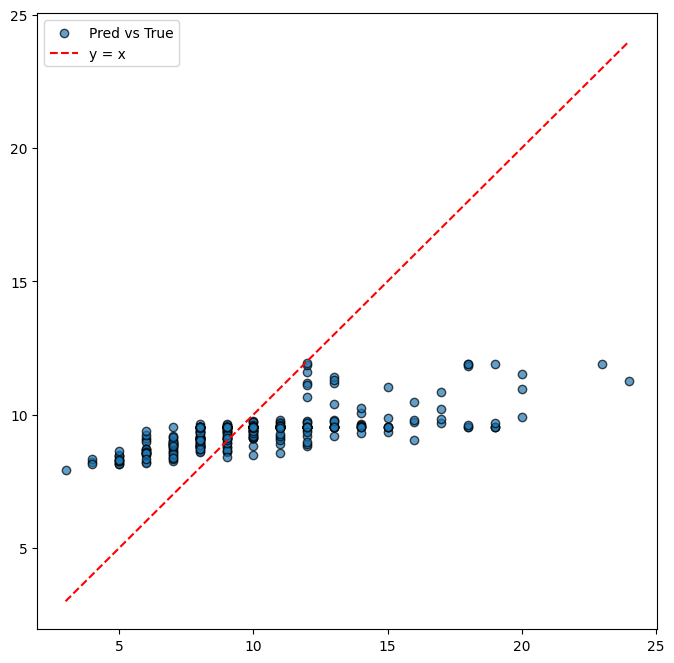

In [138]:
import matplotlib.pyplot as plt

# 산점도 그리기
plt.figure(figsize=(8,8))
plt.scatter(targets, preds, alpha=0.7, label = 'Pred vs True', edgecolor='k')

# 비교를 위한 y = x 직선 그리기
min_val = min(min(targets), min(preds))
max_val = max(max(targets), max(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label = 'y = x')

# 레이블 및 범례
plt.legend()
plt.show()

그래프 해석

- **파란 점**: 모델이 예측한 값과 실제 타깃값의 산점도.
- **빨간 점선(y = x)**: 이상적인 예측 결과를 나타냄.
- 점들이 점선에 가까울수록 예측이 잘 된 것.
    - 특정 구간에서 예측 성능이 좋지 않거나 과소/과대 예측된 영역을 확인 가능.

## 모델 저장과 불러오기

PyTorch에서 학습한 모델을 저장하고, 저장된 모델을 다시 불러오는 방법을 배우겠습니다.

모델 저장과 복원을 통해 학습된 결과를 재사용하고 효율적인 실험을 진행할 수 있습니다.

#### 모델 저장

**`torch.save()` 함수**

PyTorch에서 모델을 저장할 때는 **`torch.save()`** 함수를 사용합니다.

모델 저장은 보통 **모델의 파라미터(state_dict)** 만 저장합니다.

In [139]:
torch.save(model.state_dict(), 'model.pth')  # 파일을 저장함

In [140]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-1.1398e-01, -3.9980e-02, -9.3612e-01,  4.7756e-01, -5.3209e-01,
                       -5.0409e-02,  4.6832e-01],
                      [-3.6204e-01,  3.1400e-01,  1.3529e-01, -2.9153e-01, -1.7530e-01,
                        1.2303e-01,  3.6592e-02],
                      [-1.9621e-01, -1.0527e-01, -1.0942e-01, -3.4192e-02,  7.8891e-02,
                       -3.5021e-02, -6.1361e-02],
                      [ 1.0221e-01,  3.4379e-02,  5.7614e-02,  3.0352e-01, -3.6314e-01,
                       -1.8561e-01,  2.5677e-02],
                      [-2.4357e-01, -2.5777e-01,  1.9999e-01, -2.4296e-01, -2.9147e-02,
                        5.8021e-02,  3.8725e-01],
                      [-1.0078e-01,  2.1669e-01, -1.2168e-01, -3.1971e-01, -2.5084e-01,
                       -1.7041e-01,  1.1027e-01],
                      [ 1.7865e-01, -3.5838e-01, -9.0503e-01, -4.3936e-01,  9.2158e-01,
                       -3.9896e-01, -8.6396e-01],
      

- **`model.state_dict()`**: 모델의 파라미터 정보를 담고 있는 딕셔너리.
- **`'model.pth'`**: 저장될 파일의 경로.

#### 모델 불러오기

저장된 모델 파일을 불러오려면 **torch.load()** 를 사용합니다.

In [141]:
state_dict_loaded = torch.load('model.pth')

결과: 파라미터 이름과 값으로 구성된 딕셔너리(state_dict_loaded).

In [142]:
state_dict_loaded

OrderedDict([('fc1.weight',
              tensor([[-1.1398e-01, -3.9980e-02, -9.3612e-01,  4.7756e-01, -5.3209e-01,
                       -5.0409e-02,  4.6832e-01],
                      [-3.6204e-01,  3.1400e-01,  1.3529e-01, -2.9153e-01, -1.7530e-01,
                        1.2303e-01,  3.6592e-02],
                      [-1.9621e-01, -1.0527e-01, -1.0942e-01, -3.4192e-02,  7.8891e-02,
                       -3.5021e-02, -6.1361e-02],
                      [ 1.0221e-01,  3.4379e-02,  5.7614e-02,  3.0352e-01, -3.6314e-01,
                       -1.8561e-01,  2.5677e-02],
                      [-2.4357e-01, -2.5777e-01,  1.9999e-01, -2.4296e-01, -2.9147e-02,
                        5.8021e-02,  3.8725e-01],
                      [-1.0078e-01,  2.1669e-01, -1.2168e-01, -3.1971e-01, -2.5084e-01,
                       -1.7041e-01,  1.1027e-01],
                      [ 1.7865e-01, -3.5838e-01, -9.0503e-01, -4.3936e-01,  9.2158e-01,
                       -3.9896e-01, -8.6396e-01],
      

1) 동일한 모델 구조 생성

저장된 파라미터는 모델 구조와 별개이므로, 동일한 모델 구조를 다시 만들어야 합니다.

In [143]:
model_loaded = AbaloneModel()
model_loaded.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.2343,  0.1177, -0.1914,  0.3699,  0.2036, -0.0648, -0.1769],
                      [ 0.1326,  0.3750,  0.2786,  0.1733, -0.2106,  0.1381, -0.3268],
                      [ 0.2402, -0.2507,  0.0137, -0.2209,  0.2629, -0.1300,  0.3602],
                      [ 0.3285,  0.2395, -0.3034,  0.3094, -0.3399, -0.1713, -0.3132],
                      [ 0.1681, -0.2521, -0.0623,  0.2585, -0.1707,  0.2346,  0.1971],
                      [-0.0362,  0.3360,  0.2354, -0.3372, -0.2960,  0.0226, -0.0419],
                      [-0.1766, -0.2696, -0.3267, -0.1508,  0.0108, -0.0004, -0.1314],
                      [ 0.3306,  0.0615,  0.2215,  0.1457, -0.2797,  0.0068,  0.2571],
                      [ 0.2769, -0.3667,  0.1552,  0.2873,  0.3512,  0.2343, -0.1911],
                      [-0.3286, -0.1134,  0.0356,  0.0741,  0.3050,  0.1406, -0.2236],
                      [ 0.2007, -0.1008,  0.1338,  0.3322, -0.3296,  0.2612,  0.1119],
               

2) 파라미터 로드

load_state_dict() 메서드를 사용해 저장된 파라미터를 모델에 로드합니다.

In [144]:
model_loaded.load_state_dict(state_dict_loaded)

<All keys matched successfully>

키 매칭: 저장된 파라미터 이름과 모델의 파라미터 이름이 매칭되어야 로드가 성공합니다.

3) 디바이스 설정   
불러온 모델을 GPU 또는 CPU에 맞게 설정합니다.

In [145]:
model_loaded.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [147]:
### 복원된 모델과 원래 모델 비교
print(model.state_dict().keys() == model_loaded.state_dict().keys())
for key in model.state_dict():
    print(key, torch.equal(model.state_dict()[key], model_loaded.state_dict()[key]))

True


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument other in method wrapper_CUDA__equal)

#### 트레이닝 루프에 저장 코드 추가

In [ ]:
# training loop
epochs = 10
step = 0
best_loss = 100000
for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        x_train, y_train = train_batch[0].to(device), train_batch[1].to(device)
        pred = model(x_train).squeeze()
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step += 1

        if step % 100 == 0:
            print(f'Loss at step {step}: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            x_val, y_val = val_batch[0].to(device), val_batch[1].to(device)
            pred_val = model(x_val).squeeze()
            loss = loss_fn(pred_val, y_val)
            losses.append(loss.item())

        val_loss_avg = sum(losses) / len(losses)
        print(f'epoch {epoch+1}/{epochs}, validation loss: {val_loss_avg:.4f}\n')

    # 에폭마다 모델 저장
    torch.save(model.state_dict(), f'model_{epoch + 1}.pth')

    if val_loss_avg < best_loss:
        torch.save(model.state_dict(), 'model.best.pth')
        best_loss = val_loss_avg

epoch 1/10, validation loss: 5.4290

Loss at step 100: 13.2147
epoch 2/10, validation loss: 5.8582

Loss at step 200: 12.5887
epoch 3/10, validation loss: 8.1207

Loss at step 300: 9.2778
epoch 4/10, validation loss: 7.7472

Loss at step 400: 6.5352
epoch 5/10, validation loss: 7.5008

epoch 6/10, validation loss: 6.6659

Loss at step 500: 7.9026
epoch 7/10, validation loss: 6.6228

Loss at step 600: 7.7782
epoch 8/10, validation loss: 6.5324

Loss at step 700: 8.1200
epoch 9/10, validation loss: 6.8259

Loss at step 800: 3.5010
epoch 10/10, validation loss: 6.5997



##### 결과

- **모델 파일 생성**: 각 에폭이 끝날 때마다 `model_1.pth`, `model_2.pth` 등의 파일이 저장됩니다.
- 저장된 모델 파일은 나중에 불러와 추가 학습 또는 추론에 사용할 수 있습니다.

## 실습

California Housing 데이터로 모델을 학습시키는 코드가 주어져 있습니다. 이제 중간중간 학습 loss 값도 프린트하고 epoch이 끝날 때마다 모델을 평가하기도 하는데요. 모델이 올바르게 동작하고 더 효율적으로 학습될 수 있도록 코드를 추가하려고 합니다. 다음의 지침을 따라서 코드를 작성해 주세요.

- `CaliforniaHousingModel`에 `Dropout` 레이어가 포함되어 있습니다. 학습 과정과 평가 과정에서 모델이 올바르게 동작하도록 코드를 추가해 주세요.
- GPU를 사용할 수 있는 환경에서는 텐서 연산이 GPU에서 이루어지도록 하고 싶습니다.

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# 데이터 불러오기
cal_housing = datasets.fetch_california_housing()
input_data = cal_housing.data.astype(np.float32)
target_data = cal_housing.target.astype(np.float32)


# CaliforniaHousingDataset 클래스 정의
class CaliforniaHousingDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor


# 학습/검증/테스트 분할
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size:train_size + val_size]
val_targets = target_data[train_size:train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

# 학습 입력 데이터 기준 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

# Dataset 객체 생성
train_dataset = CaliforniaHousingDataset(train_inputs_scaled, train_targets)
val_dataset = CaliforniaHousingDataset(val_inputs_scaled, val_targets)
test_dataset = CaliforniaHousingDataset(test_inputs_scaled, test_targets)

# DataLoader 객체 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)


In [ ]:
# 학습코드

# 참고

## (참고) torch.nn.functional

# `nn`에서 객체를 활용하는 방식

지금까지 모델을 정의할 때 레이어나 활성화 함수를 객체로 만들어 사용했습니다. 모델 안에서 다른 모델을 쓸 때도 객체로 만들어 사용했고요. 모델을 학습시킬 때 손실 함수 역시 객체를 활용했어요. 이 객체들은 모두 `nn.Module`을 상속받은 클래스로 만들어진 객체였습니다.

모델 구성 요소를 객체로 다루면 `nn.Module`이 가진 속성과 메소드를 모두 사용할 수 있기 때문에 좋은 점이 많습니다. 예를 들어 weight나 bias처럼 학습 과정에서 업데이트되는 파라미터를 관리하는 게 편해지죠. 일단 객체로 만들어 놓은 요소는 재사용성이 좋아 여기저기서 가져다 사용하기도 쉽습니다.

그런데 때로는 위에서 언급한 장점이 별로 필요하지 않을 수도 있습니다. 특히 대부분의 활성화 함수나 손실 함수, 그리고 일부 레이어는 학습 때 업데이트할 파라미터가 따로 없습니다. 간단한 일회성 연산이 필요한 경우라면 재사용성도 큰 의미가 없죠.

# `torch.nn.functional` 활용하기

그래서 PyTorch에는 모델을 정의하고 학습시킬 때 사용 가능한 '함수'들이 존재합니다. 바로 `torch.nn.functional`에서 제공하는 함수들인데요. 객체를 만들지 않아도 동일한 연산을 함수 형태로 편리하게 수행할 수 있습니다.

`torch.nn.functional`은 일반적으로 아래처럼 `F`라는 이름으로 가져옵니다.

```python
import torch.nn.functional as F
```

간단하게 ReLU 활성화 함수부터 예로 들어 볼게요. `ReLU` 객체를 활용할 경우에는 다음처럼 활성화 함수를 적용할 수 있습니다.

```python
relu = nn.ReLU()
y = relu(x)
```

객체를 만들지 않고 `F.relu()` 함수를 사용하면 같은 결과를 얻을 수 있어요.

```python
y = F.relu(x)
```

손실 함수도 살펴보겠습니다. 다음은 `MSELoss` 객체를 활용해 `pred`와 `y_train` 사이의 평균 제곱 오차를 구하는 코드입니다.

```python
loss_fn = nn.MSELoss()
loss = loss_fn(pred, y_train)
```

위 코드는 다음처럼 `F.mse_loss()` 함수를 활용하는 코드로 바꿀 수 있어요. `MSELoss` 객체를 만들지 않고 함수를 통해 loss 값을 계산합니다.

```python
loss = F.mse_loss(pred, y_train)
```

함수 형태로 사용하기 좋은 대표적인 레이어는 컨볼루셔널 신경망(CNN)에서 자주 볼 수 있는 풀링(pooling) 레이어입니다. 풀링 연산은 특정한 범위 내에서 최댓값이나 평균을 구하는 연산이에요. 풀링 레이어는 단순히 입력 텐서에 대해 풀링 연산을 수행할 뿐이며, 따로 weight나 bias 같은 파라미터를 관리할 필요가 없습니다.

객체를 사용한다면 다음 코드처럼 `MaxPool2d` 객체를 만들면 되고요.

```python
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
y = maxpool(x)
```

아래 코드처럼 `F.max_pool2d()` 함수를 사용해도 같은 결과가 나옵니다.

```python
y = F.max_pool2d(x, kernel_size=2, stride=2)
```

일반적으로는 활성화 함수나 손실 함수는 객체가 아닌 함수 형태로 사용해도 괜찮은 경우가 많습니다. 반면 레이어는 대부분 학습 때 업데이트되는 파라미터가 있다 보니 함수보다는 객체 형태로 사용하는 게 편리해요. 상황에 따라 객체 형태와 함수 형태 중 적절한 방식을 선택하면 됩니다.

## (참고) in-place 메소드

PyTorch 텐서 객체에는 여러 가지 연산 메소드가 있는데요. 보통 텐서에서 메소드를 호출하면 메소드를 호출한 원본 텐서에는 변화가 없고, 연산이 적용된 텐서를 리턴받아 사용하게 됩니다.

예를 들어 앞서 배운 `squeeze()` 메소드를 살펴볼게요. 1x4 텐서를 만든 다음 `squeeze()` 메소드를 호출하면 크기가 1인 0번 차원이 제거된 텐서가 리턴됩니다. 이때 메소드를 호출한 원본 텐서에는 연산이 적용되지 않습니다. 그래서 아래 코드에서 원본 텐서 `x`는 여전히 1x4 형태의 2차원 텐서이지만, `x_sq`는 차원이 하나 제거되어 크기가 4인 1차원 텐서가 되죠.

```python
x = torch.ones(1, 4)
x_sq = x.squeeze()
print(x.size())  # torch.Size([1, 4])
print(x_sq.size())  # torch.Size([4])
```

그런데 텐서의 메소드 중에는 in-place 버전이 함께 존재하는 경우가 있습니다. 텐서에서 in-place 메소드를 호출하면, 메소드를 호출한 원본 텐서에 연산이 적용돼요.

이번에는 `squeeze()` 메소드의 in-place 버전을 살펴보겠습니다. PyTorch 텐서의 in-place 메소드는 대부분 원래 메소드 이름 끝에 `_`를 붙이면 사용할 수 있어요. 즉, `squeeze_()`라는 메소드로 차원 제거 in-place 연산을 수행할 수 있습니다. 아래 코드를 보면, `x`가 `squeeze_()` 메소드를 호출해서 `x` 스스로 차원을 하나 제거해 크기가 4인 1차원 텐서가 됩니다.

```python
x = torch.ones(1, 4)
x.squeeze_()
print(x.size())  # torch.Size([4])
```

In-place 메소드는 원본 텐서의 메모리를 재사용하여 연산을 수행하기 때문에 메모리를 절약할 수 있습니다. 그런데 역전파로 gradient를 계산하려면 텐서 연산을 모두 기록해야 된다고 했죠? In-place 연산을 거치면서 텐서의 값이 수정되면 그동안 기록한 연산 내용이 손실될 위험이 있습니다. 그렇게 되면 PyTorch의 편리한 자동 미분 기능을 사용하지 못할 수도 있는 거죠. 게다가 원본 텐서의 값을 바꾸면서 예상치 못한 부작용이 발생할 때도 있으니 주의해야 합니다.

그래서 in-place 메소드를 사용한다면, 되도록 역전파 연산이 필요하지 않거나 복잡하지 않은 문맥에서만 사용하는 게 좋아요. 코드를 안전하게 작성하고 싶다면 그냥 in-place 메소드를 쓰지 않는 걸 권장합니다.

그럼에도 이렇게 in-place 메소드에 대해 설명드리는 이유는 다른 사람이 작성한 코드를 볼 때 in-place 메소드를 마주칠 수도 있기 때문입니다. 이제 코드를 볼 때, 메소드 이름이 `_`로 끝나고 메소드 결과를 변수에 따로 할당하지 않는다면 in-place 메소드가 사용되었다는 걸 알 수 있겠죠?